# Graph Neural Networks

In [1]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2022-02-24 18:18:25.079026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:/hits/fast/mbm/software/gaussian/g09d1/g09:
2022-02-24 18:18:25.079113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import nfp
from collections import namedtuple
from rdkit import RDLogger, Chem

In [20]:
from graphviz import Digraph

In [3]:
### Load input data ###
data = pd.read_pickle('data_complete_final')
data.dropna(axis = 1, inplace = True)
data = data.drop(columns = [
    'rad_name', 'h_name', 'hash_u1', 'hash_u2', 'e_max_key', 'e_max', 'e_00', 'e_03', 'e_04',
    'e_05', 'e_06', 'e_07', 'e_10', 'meta_path', 'dG', 'rad_name_s',
    'h_name_s', 'reaction', 'trans_mean', 'Ea_trans_mean', 'rad_ref',
    'rad_ref_idx', 'h_ref', 'h_ref_idx', 'bur_vol_default_rad', 'bur_vol_2A_rad',
    'bur_vol_default_H', 'bur_vol_2A_H'
], axis = 1)

In [3]:
data.columns

Index(['translation', 'rad_charge', 'h_charge', 'Ea', 'rad_chem_name',
       'H_chem_name', 'rad_ref_comp', 'H_ref_comp', 'rad_BDE', 'H_BDE',
       'rad_BDE_G', 'H_BDE_G', 'pdb_rad', 'SMILES_rad', 'max_spin_rad',
       'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
       'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
       'pdb_H', 'SMILES_H', 'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
       'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H',
       'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H', 'pdb_file_start',
       'morgan_start', 'soap_rad_start', 'soap_H_start', 'lmbtr_rad_start',
       'lmbtr_H_start', 'SMILES_sys_start', 'pdb_file_end', 'morgan_end',
       'soap_rad_end', 'soap_H_end', 'lmbtr_rad_end', 'lmbtr_H_end',
       'SMILES_sys_end'],
      dtype='object')

In [ ]:
# compute enthalpies of reaction to use as a direct input
BDE_rad = data['rad_BDE']
BDE_H = data['H_BDE']
Delta_H = BDE_H - BDE_rad
Delta_H_df = pd.DataFrame(Delta_H, columns=['Delta_H'])

In [2]:
def plot_loss(history, no_epochs, title):
    fs = 18
    fig, ax = plt.subplots(figsize = (10,10))
    ax.plot(history.history['loss'], label='Loss')
    ax.plot(history.history['val_loss'], label='Validation loss')
    ax.set_xlim([0, no_epochs])
    ax.set_xlabel('Epoch', fontsize = fs)
    ax.set_ylabel('Error [kcal/mol]', fontsize = fs)
    ax.tick_params(labelsize = fs)
    plt.legend(fontsize = fs)
    plt.grid(True)
    plt.title(title, fontsize = fs)
    plt.show()

def plot_predictions(model, test_features, test_labels, title):
    fs = 18
    fig, ax = plt.subplots(figsize = (10,10))
    test_predictions = model.predict(test_features).flatten()
    ax.scatter(test_predictions, test_labels)
    ax.set_xlabel('Predicted Barrier [kcal/mol]', fontsize = fs)
    ax.set_ylabel('True Barrier [kcal/mol]', fontsize = fs)
    lims = [0, max(test_labels)+10]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims)
    ax.tick_params(labelsize = fs)
    plt.title(title, fontsize = fs)
    plt.show()

def plot_errors(model, test_features, test_labels, title):
    fs = 18
    fig, ax = plt.subplots(figsize = (10,10))
    test_predictions = model.predict(test_features).flatten()
    error = test_predictions - test_labels
    ax.hist(error, bins=5)
    ax.set_xlabel('Prediction error [kcal/mol]', fontsize = fs)
    ax.set_ylabel('Count', fontsize = fs)
    lims = [0, max(test_labels)+10]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims)
    ax.tick_params(labelsize = fs)
    plt.title(title, fontsize = fs)
    plt.show()

def K_fold_cross_validation(
  inputs, targets, num_folds, model, mixed_dtypes, loss='MSLE', metrics = ['mae'], batch_size = 100, no_epochs = 500, verbose = 0,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    mae_per_fold = []
    loss_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=inputs.shape[0]*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
  
        model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if mixed_dtypes:
            # inputs will be a DataFrame
            input_train_dict = {}
            input_train_dict = {name: np.array(value) 
                         for name, value in inputs.iloc[train,:].items()}
    
            history = model.fit(input_train_dict, targets[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbose,
                        validation_split=split,
                        callbacks=callbacks)

            input_test_dict = {}
            input_test_dict = {name: np.array(value) 
                         for name, value in inputs.iloc[test,:].items()}

            scores = model.evaluate(input_test_dict, targets[test], verbose=0)

        else:
            # inputs will be a np.array
            history = model.fit(inputs[train], targets[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbose,
                        validation_split=split,
                        callbacks=callbacks)
            scores = model.evaluate(inputs[test], targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        mae_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])
      
        fold_no = fold_no + 1
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(mae_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MAE: {mae_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')
  
    return mae_per_fold, loss_per_fold

def plot_cross_val_scores(dataframe):
    fs = 18
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set_style('ticks')
    ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=dataframe, inner=None, orient='v')
    ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=dataframe, color='black', edgecolor='black', size=8)
    ax.tick_params(labelsize = fs)
    ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
    ax.set_xlabel('Model', fontsize=fs)
    ax.grid(linestyle='--', linewidth=1)

def plot_results(y_train_pred, y_train_true, y_val_pred, y_val_true, y_test_pred, y_test_true, title_text):
    fs = 18
    color_train = 'b'
    color_validation = 'orange'
    color_test = 'g'
    size = 30
    alpha = 1
    fig, ax = plt.subplots(figsize=(10,10))
    sb.set(font_scale=1.2, style="ticks")
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.text(0.5, 1.08, title_text, horizontalalignment='center',
         fontsize=14, fontweight='bold', transform = ax.transAxes)

    points_train = ax.scatter(y_train_true, y_train_pred,
                c = color_train, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)
    points_validation = ax.scatter(y_val_true, y_val_pred,
                c = color_validation, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)
    points_test = ax.scatter(y_test_true, y_test_pred,
                c = color_test, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)
    plot = ax.set(ylabel='Predicted barrier [kcal/mol]', xlabel='True barrier [kcal/mol]')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
            fancybox=True, shadow=True, ncol=5, labels=['Training','Validation','Test'])

    # Add the regression line with a confidence interval based on the training sets
    plot = sb.regplot(y_train_true, y_train_pred, scatter=False, color=".1", truncate = False, ax=ax)
    ax.grid(linestyle='--', linewidth=1)

    y_compl = y_train_true + y_val_true + y_test_true + y_train_pred + y_val_pred + y_test_pred 
    size_space = 0.1*abs(min(y_compl)-max(y_compl))
    min_value_graph = min(y_compl)-size_space
    max_value_graph = max(y_compl)+size_space
    plt.xlim(min_value_graph, max_value_graph)
    plt.ylim(min_value_graph, max_value_graph)
        
    plt.show()

In [21]:
def plot_nn(names, shapes, activations, file_name, title):
    lengths = [len(names), len(shapes), len(activations)]
    lengths_comp = [len(names) for i in range(3)]
    assert np.allclose(lengths, lengths_comp), 'All input lists must be of the same length.'

    dot = Digraph(
        node_attr={'shape': 'box', 'fillcolor': 'lightblue2', 'style': 'filled'},
    )
    dot.attr(label=title)
    for i, n, s, a in zip(range(len(names)), names, shapes, activations):
        if s != None:
            dot.node('L{}'.format(i), '{}\n{} nodes\nActivation: {}'.format(n, s, a))
        else:
            dot.node('L{}'.format(i), '{}'.format(n))

    for i, j in zip(range(len(names)-1), range(1,len(names))):
        dot.edge('L{}'.format(i), 'L{}'.format(j))
        
    dot.format = 'png'
    dot.render(file_name)

# Simple GNN

In [4]:
data_simple_GNN = data[[
    'Ea', 'pdb_file_start', 'translation', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H', 
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H',
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]

In [5]:
data_simple_GNN.shape

(6150, 27)

In [6]:
data_simple_GNN.head()

,Ea,pdb_file_start,translation,rad_BDE,H_BDE,max_spin_rad,mull_charge_rad,bur_vol_iso_rad,nBase_rad,SpMax_A_rad,...,bur_vol_iso_H,nBase_H,SpMax_A_H,ATSC2s_H,ATSC1Z_H,ATSC2i_H,GATS2dv_H,BCUTdv-1h_H,SMR_VSA4_H,VSA_EState7_H
3,24.015357,/hits/basement/mbm/riedmiki/structures/KR0008/...,0.803510,428.455386,420.058916,0.747624,-0.327401,21.729674,1.0,2.210002,...,26.939279,0.0,2.234199,7.815746,-11.378698,-8.747466,0.860732,6.023147,0.000000,-0.894583
5,77.910666,/hits/basement/mbm/riedmiki/structures/KR0008/...,1.994497,372.355494,420.058916,0.616795,-0.333943,24.571488,1.0,2.210002,...,26.939279,0.0,2.234199,7.815746,-11.378698,-8.747466,0.860732,6.023147,0.000000,-0.894583
7,82.975614,/hits/basement/mbm/riedmiki/structures/KR0008/...,2.010190,411.626339,420.058916,0.689562,-0.164075,20.043393,1.0,2.210002,...,26.939279,0.0,2.234199,7.815746,-11.378698,-8.747466,0.860732,6.023147,0.000000,-0.894583
8,46.375719,/hits/basement/mbm/riedmiki/structures/KR0008/...,1.342340,402.349610,420.058916,0.626425,-0.354471,18.511967,1.0,2.210002,...,26.939279,0.0,2.234199,7.815746,-11.378698,-8.747466,0.860732,6.023147,0.000000,-0.894583
14,74.008139,/hits/basement/mbm/riedmiki/structures/KR0008/...,2.014465,372.355494,399.832892,0.616795,-0.333943,24.571488,1.0,2.210002,...,24.780554,0.0,2.234199,13.527778,-6.413265,-3.563913,0.835067,6.023145,5.917906,0.000000


In [7]:
atom_type = namedtuple(
    'Atom', ['symbol', 'charge', 'aromatic', 'degree', 'totalHs']
)
bond_type = namedtuple(
    'Bond', ['bond_type', 'degree']
)

def atom_featurizer(atom):
    """ Return an integer hash representing the atom type
    """

    return atom_type(
        atom.GetSymbol(),
        atom.GetFormalCharge(),
        atom.GetIsAromatic(),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())

    return bond_type(atoms, btype)

preprocessor = nfp.MolPreprocessor(atom_features=atom_featurizer,
                                    bond_features=bond_featurizer)

In [8]:
### split the data into training and test sets ###
data_simple_GNN_val = data_simple_GNN.sample(frac=0.2, random_state=1)
data_simple_GNN_test = data_simple_GNN[~data_simple_GNN.index.isin(data_simple_GNN_val.index)].sample(frac=0.2, random_state=1)
data_simple_GNN_train = data_simple_GNN[~data_simple_GNN.index.isin(data_simple_GNN_test.index) & ~data_simple_GNN.index.isin(data_simple_GNN_val.index)]

In [29]:
### Initially, the preprocessor has no data on atom types, so we have to loop over the training
### data set once to pre-allocate these mappings
RDLogger.DisableLog('rdApp.*')
print('Before pre-allocating:', preprocessor.atom_tokenizer._data)

for file in data_simple_GNN['pdb_file_start']:
    mol = Chem.MolFromPDBFile(str(file.resolve()))
    preprocessor(mol, train=True)

print('After pre-allocating:', preprocessor.atom_tokenizer._data)

Before pre-allocating: {'unk': 1}
After pre-allocating: {'unk': 1, Atom(symbol='O', charge=0, aromatic=False, degree=1, totalHs=1): 2, Atom(symbol='N', charge=0, aromatic=False, degree=1, totalHs=2): 3, Atom(symbol='C', charge=0, aromatic=False, degree=2, totalHs=2): 4, Atom(symbol='C', charge=0, aromatic=False, degree=3, totalHs=1): 5, Atom(symbol='C', charge=0, aromatic=False, degree=3, totalHs=0): 6, Atom(symbol='O', charge=0, aromatic=False, degree=1, totalHs=0): 7, Atom(symbol='C', charge=0, aromatic=False, degree=1, totalHs=3): 8, Atom(symbol='N', charge=0, aromatic=False, degree=2, totalHs=1): 9, Atom(symbol='C', charge=0, aromatic=False, degree=2, totalHs=1): 10, Atom(symbol='S', charge=0, aromatic=False, degree=1, totalHs=1): 11, Atom(symbol='H', charge=0, aromatic=False, degree=0, totalHs=1): 12, Atom(symbol='S', charge=0, aromatic=False, degree=2, totalHs=0): 13, Atom(symbol='N', charge=1, aromatic=False, degree=1, totalHs=3): 14, Atom(symbol='N', charge=0, aromatic=False, d

In [30]:
# construct feature matrices
for file in data_simple_GNN['pdb_file_start']:
    mol = Chem.MolFromPDBFile(str(file.resolve()))
    preprocessor.__call__(mol, train=True)

In [31]:
def data_generator(data_split):
  for _, row in data_split.iterrows():
    mol = Chem.MolFromPDBFile(str(row.pdb_file_start.resolve()))
    inputs = preprocessor.__call__(mol, train=False)
    yield ({'atom': inputs['atom'],
           'bond': inputs['bond'],
           'connectivity': inputs['connectivity']},
           row.Ea)

output_signature = ({
  'atom': tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'bond': tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'connectivity': tf.TensorSpec(shape=(None, 2), dtype=tf.int32, name=None)
}, tf.TensorSpec(shape=(), dtype=tf.float32))

In [32]:
# Construct the tf.data pipeline
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_train),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_val),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_test),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
### Define the keras model ###
# Input tf.keras.layers
atom = tf.keras.layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond = tf.keras.layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

# Controls the size of the model
num_features = 64

# Convert from a single integer defining the atom state to a vector of weights associated with that class
atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

# Dito with the bond state
bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

# Message passing
for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])

mol_prediction = tf.keras.layers.Dense(1)(atom_state)

gnn_model = tf.keras.Model([atom, bond, connectivity], [mol_prediction])


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=6150*0.8/32*1000, decay_rate=1, staircase=False
)
optimizer=tf.keras.optimizers.Adam(lr_schedule)
gnn_model.compile(optimizer, loss='mae')

In [34]:
hist = gnn_model.fit(train_dataset, validation_data=valid_dataset, epochs=100, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20), verbose=0)

2022-02-10 23:39:02.008624: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: RuntimeError: Range Error
	atomId
	Violation occurred on line 62 in file Code/GraphMol/Conformer.cpp
	Failed Expression: 10 < 8
	RDKIT: 2021.09.2
	BOOST: 1_76

Traceback (most recent call last):

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_1334962/1786262994.py", line 4, in data_generator
    inputs = preprocessor.__call__(mol, train=False)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/pyth

UnknownError:  RuntimeError: Range Error
	atomId
	Violation occurred on line 62 in file Code/GraphMol/Conformer.cpp
	Failed Expression: 10 < 8
	RDKIT: 2021.09.2
	BOOST: 1_76

Traceback (most recent call last):

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_1334962/1786262994.py", line 4, in data_generator
    inputs = preprocessor.__call__(mol, train=False)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/nfp/preprocessing/preprocessor.py", line 80, in __call__
    edge_features = self.get_edge_features(nx_graph.edges(data=True), max_num_edges)

  File "/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/nfp/preprocessing/mol_preprocessor.py", line 50, in get_edge_features
    self.bond_features(bond_dict['bond'], flipped=flipped))

  File "/tmp/ipykernel_1334962/4043787731.py", line 37, in bond_featurizer
    end_pos = mol.GetConformer().GetAtomPosition(end)

RuntimeError: Range Error
	atomId
	Violation occurred on line 62 in file Code/GraphMol/Conformer.cpp
	Failed Expression: 10 < 8
	RDKIT: 2021.09.2
	BOOST: 1_76



	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_101050]

In [14]:
gnn_model.evaluate(test_dataset)

31/31 [==============================] - 9s 219ms/step - loss: 15.8633


15.863279342651367

In [25]:
dot = Digraph(
    node_attr={'shape': 'box', 'fillcolor': 'lightblue2', 'style': 'filled'},
)
# dot.attr(label='Simple GNN architecture')

dot.node('A', 'Atom features\nInteger hash')
dot.node('B', 'Bond features\nInteger hash')

with dot.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='lightgrey')
    c.node('E1', 'Atom embedding\n128-dim. vector')
    c.node('E2', 'Bond embedding\n128-dim. vector')
    c.attr('node', shape='Msquare')
    c.node('MP', 'Message passing\n6 layers')
    c.attr('node', shape='box')
    c.node('E3','Final atom embedding')
    c.node('AP', 'Hidden Layer\n1 Node\nNo activation')
    c.edge('E1', 'MP')
    c.edge('E2', 'MP')
    c.edge('MP', 'E3')
    c.edge('E3', 'AP')
    c.attr(label='Graph processing')

with dot.subgraph(name='cluster_1') as c:
    c.node('AM', 'Atom mean\nScalar')
    c.attr(color='white')

dot.edge('A', 'E1')
dot.edge('B', 'E2')
dot.edge('A', 'AM')
dot.node('Av', 'Global average pooling')
dot.node('Out', 'Output layer')
dot.edge('AP', 'Av')
dot.edge('AM', 'Av')
dot.edge('Av', 'Out')

dot.format = 'png'
dot.render('simple_GNN')

'simple_GNN.png'

In [26]:
dot = Digraph(
    node_attr={'shape': 'box', 'fillcolor': 'lightblue2', 'style': 'filled'},
)
# dot.attr(label='Simple GNN architecture')

dot.node('A', 'Atom features\nInteger hash')
dot.node('B', 'Bond features\nInteger hash')

with dot.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='lightgrey')
    c.node('E1', 'Atom embedding\n64-dim. vector')
    c.node('E2', 'Bond embedding\n64-dim. vector')
    c.attr('node', shape='Msquare')
    c.node('MP', 'Message passing\n6 layers')
    c.attr('node', shape='box')
    c.node('E3','Final atom embedding')
    c.edge('E1', 'MP')
    c.edge('E2', 'MP')
    c.edge('MP', 'E3')
    c.attr(label='Graph processing')

dot.edge('A', 'E1')
dot.edge('B', 'E2')
dot.node('Out', 'Output layer')
dot.edge('E3', 'Out')

dot.format = 'png'
dot.render('simple_GNN_pdbinput')

'simple_GNN_pdbinput.png'

## Additionally supply descriptors

In [15]:
def data_generator(data_split):
  for _, row in data_split.iterrows():
    mol = Chem.MolFromPDBFile(str(row.pdb_file_start.resolve()))
    inputs = preprocessor.__call__(mol, train=False)
    yield ({'atom': inputs['atom'],
           'bond': inputs['bond'],
           'connectivity': inputs['connectivity'],
           'input_desc': [
              row.translation, row.rad_BDE, row.H_BDE,
              row.max_spin_rad, row.mull_charge_rad, row.bur_vol_iso_rad, 
              row.nBase_rad, row.SpMax_A_rad, row.ATSC2s_rad, row.ATSC1Z_rad,
              row.ATSC2i_rad, row.NdNH_rad, row.SMR_VSA4_rad,
              row.max_spin_H, row.mull_charge_H, row.bur_vol_iso_H,
              row.nBase_H, row.SpMax_A_H, row.ATSC2s_H, row.ATSC1Z_H,
              row.ATSC2i_H, row.GATS2dv_H, row['BCUTdv-1h_H'], row.SMR_VSA4_H,
              row.VSA_EState7_H
            ]},
           row.Ea)

output_signature = ({
  'atom': tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'bond': tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'connectivity': tf.TensorSpec(shape=(None, 2), dtype=tf.int32, name=None),
  'input_desc': tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)
}, tf.TensorSpec(shape=(), dtype=tf.float32))

In [16]:
# Construct the tf.data pipeline
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_train),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_val),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_test),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
### Define the keras model ###
# Input tf.keras.layers
atom = tf.keras.layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond = tf.keras.layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')
input_desc = tf.keras.layers.Input(shape=[25], dtype=tf.float32, name='input_desc')

# Controls the size of the model
num_features = 64

# Convert from a single integer defining the atom state to a vector of weights associated with that class
atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

# Dito with the bond state
bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

out = tf.keras.layers.Dense(
  64, activation='relu'
)(input_desc)
out = tf.keras.layers.BatchNormalization()(out)
out = tf.keras.layers.Dense(
  32, activation='relu'
)(out)
out = tf.keras.layers.BatchNormalization()(out)
descriptors = tf.keras.layers.Dense(1)(out)

# Message passing
for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])

atomwise_prediction = tf.keras.layers.Dense(1)(atom_state)
combined_prediction = tf.keras.layers.Add()([atomwise_prediction, descriptors])
mol_prediction = tf.keras.layers.Dense(1)(combined_prediction)

gnn_model = tf.keras.Model([atom, bond, connectivity, input_desc], [mol_prediction])


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=6150*0.8/32*1000, decay_rate=1, staircase=False
)
optimizer=tf.keras.optimizers.Adam(lr_schedule)
gnn_model.compile(optimizer, loss='mae')

In [18]:
hist = gnn_model.fit(train_dataset, validation_data=valid_dataset, epochs=100, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20), verbose=0)

In [19]:
gnn_model.evaluate(test_dataset)

2022-02-10 22:11:59.660745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1 of 200
2022-02-10 22:12:01.389928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


31/31 [==============================] - 21s 236ms/step - loss: 16.0204


16.02044677734375

In [102]:
gnn_model.evaluate(test_dataset)

31/31 [==============================] - 9s 233ms/step - loss: 15.7164


15.716423988342285

In [28]:
dot = Digraph(
    node_attr={'shape': 'box', 'fillcolor': 'lightblue2', 'style': 'filled'},
)
# dot.attr(label='Simple GNN architecture')

dot.node('A', 'Atom features\nInteger hash')
dot.node('B', 'Bond features\nInteger hash')
dot.node('D', 'Additional descriptors\n(Distance, BDEs, ...')

with dot.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='lightgrey')
    c.node('E1', 'Atom embedding\n64-dim. vector')
    c.node('E2', 'Bond embedding\n64-dim. vector')
    c.attr('node', shape='Msquare')
    c.node('MP', 'Message passing\n6 layers')
    c.attr('node', shape='box')
    c.node('E3','Final atom embedding')
    c.node('AP', 'Hidden Layer\n1 Node\nNo activation')
    c.edge('E1', 'MP')
    c.edge('E2', 'MP')
    c.edge('MP', 'E3')
    c.edge('E3', 'AP')
    c.attr(label='Graph processing')

with dot.subgraph(name='cluster_1') as c:
    c.node('H1', 'Hidden Layer\n64 nodes\nActivation: ReLu')
    c.node('B1', 'Batch Normalization')
    c.node('H2', 'Hidden Layer\n32 nodes\nActivation: ReLu')
    c.node('B2', 'Batch Normalization')
    c.node('H3', 'Hidden Layer\n1 node\nNo Activation')
    c.edge('H1', 'B1')
    c.edge('B1', 'H2')
    c.edge('H2', 'B2')
    c.edge('B2', 'H3')
    c.attr(color='white')

dot.edge('A', 'E1')
dot.edge('B', 'E2')
dot.edge('D', 'H1')
dot.node('Out', 'Output layer')
dot.edge('AP', 'Out')
dot.edge('H3', 'Out')

dot.format = 'png'
dot.render('simple_GNN_pdbinput_desc')

'simple_GNN_pdbinput_desc.png'

## Use distances as input

In [15]:
atom_type = namedtuple(
    'Atom', ['symbol', 'charge', 'aromatic', 'degree', 'totalHs']
)
bond_type = namedtuple(
    'Bond', ['bond_type', 'degree']
)

def atom_featurizer(atom):
    """ Return an integer hash representing the atom type
    """

    return atom_type(
        atom.GetSymbol(),
        atom.GetFormalCharge(),
        atom.GetIsAromatic(),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

# def bond_featurizer(bond, flipped=False):
#     """ Get a similar classification of the bond type.
#     Flipped indicates which 'direction' the bond edge is pointing. """
    
#     if not flipped:
#         atoms = "{}-{}".format(
#             *tuple((bond.GetBeginAtom().GetSymbol(),
#                     bond.GetEndAtom().GetSymbol())))
#     else:
#         atoms = "{}-{}".format(
#             *tuple((bond.GetEndAtom().GetSymbol(),
#                     bond.GetBeginAtom().GetSymbol())))
    
#     btype = str(bond.GetBondType())

#     return bond_type(atoms, btype)

def get_distances(mol):
    lengths = []
    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        start_pos = mol.GetConformer().GetAtomPosition(start)
        end_pos = mol.GetConformer().GetAtomPosition(end)
        l = np.sqrt((start_pos.x-end_pos.x)**2 + (start_pos.y-end_pos.y)**2 + (start_pos.z-end_pos.z)**2)
        lengths.append(l)

    return lengths + lengths # nfp counts every edge twice

preprocessor = nfp.MolPreprocessor(atom_features=atom_featurizer)
                                    # bond_features=bond_featurizer)

In [16]:
RDLogger.DisableLog('rdApp.*')
bond_lengths = []
for file in data_simple_GNN['pdb_file_start']:
    mol = Chem.MolFromPDBFile(str(file.resolve()))
    l = get_distances(mol)
    bond_lengths.append(l)
    preprocessor(mol, train=True)

In [17]:
bond_lengths_arr = np.array(bond_lengths, dtype=object)

In [18]:
bond_lengths_df = pd.DataFrame(bond_lengths_arr, columns=['bond_lengths'])
data_simple_GNN_with_bl = data_simple_GNN.reset_index()
data_simple_GNN_with_bl = data_simple_GNN_with_bl.join(bond_lengths_df)

In [19]:
# construct feature matrices
for file in data_simple_GNN_with_bl['pdb_file_start']:
    mol = Chem.MolFromPDBFile(str(file.resolve()))
    preprocessor.__call__(mol, train=True)

def data_generator(data_split):
  for _, row in data_split.iterrows():
    mol = Chem.MolFromPDBFile(str(row.pdb_file_start.resolve()))
    inputs = preprocessor.__call__(mol, train=False)
    yield ({'atom': inputs['atom'],
          #  'bond': inputs['bond'],
           'connectivity': inputs['connectivity'],
           'bond_lengths': row.bond_lengths},
           row.Ea)

output_signature = ({
  'atom': tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  # 'bond': tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'connectivity': tf.TensorSpec(shape=(None, 2), dtype=tf.int32, name=None),
  'bond_lengths': tf.TensorSpec(shape=(None,), dtype=tf.float32, name=None)
}, tf.TensorSpec(shape=(), dtype=tf.float32))

In [20]:
data_simple_GNN_with_bl_val = data_simple_GNN_with_bl.sample(frac=0.2, random_state=1)
data_simple_GNN_with_bl_test = data_simple_GNN_with_bl[~data_simple_GNN_with_bl.index.isin(data_simple_GNN_with_bl_val.index)].sample(frac=0.2, random_state=1)
data_simple_GNN_with_bl_train = data_simple_GNN_with_bl[~data_simple_GNN_with_bl.index.isin(data_simple_GNN_with_bl_test.index) & ~data_simple_GNN_with_bl.index.isin(data_simple_GNN_with_bl_val.index)]

In [21]:
# Construct the tf.data pipeline
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_with_bl_train),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_with_bl_val),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(data_simple_GNN_with_bl_test),
    output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=32)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
### Define the keras model ###
# Input tf.keras.layers
atom = tf.keras.layers.Input(shape=[None], dtype=tf.int64, name='atom')
# bond = tf.keras.layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')
bond_lengths = tf.keras.layers.Input(shape=[None], dtype=tf.float32, name='bond_lengths')

# Controls the size of the model
num_features = 64

# Convert from a single integer defining the atom state to a vector of weights associated with that class
atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features, name='atom_embedding', mask_zero=True)(atom)
# bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features, name='bond_embedding', mask_zero=True)(bond)

bond_state = nfp.RBFExpansion(dimension=64, init_gap=0.5, init_max_distance=10)(bond_lengths)
# bond_state = tf.keras.layers.Concatenate()([bond_state, bond_dist])
# bond_state = tf.keras.layers.Dense(num_features)(bond_state)

# Message passing
for _ in range(6):
  new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity])
  bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])

  new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity])
  atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])

mol_prediction = tf.keras.layers.Dense(1)(atom_state)

gnn_model = tf.keras.Model([atom, connectivity, bond_lengths], [mol_prediction])


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=6150*0.8/32*1000, decay_rate=1, staircase=False
)
optimizer=tf.keras.optimizers.Adam(lr_schedule)
gnn_model.compile(optimizer, loss='mae')

In [23]:
hist = gnn_model.fit(train_dataset, validation_data=valid_dataset, epochs=100, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20), verbose=1)

Epoch 1/100
123/123 [==============================] - 25s 128ms/step - loss: 11478.5117 - val_loss: 1499.8021
Epoch 2/100
123/123 [==============================] - 10s 82ms/step - loss: 3522.0586 - val_loss: 3520.5776
Epoch 3/100
123/123 [==============================] - 18s 144ms/step - loss: 737.9759 - val_loss: 388.9251
Epoch 4/100
123/123 [==============================] - 16s 127ms/step - loss: 138.2115 - val_loss: 123.4003
Epoch 5/100
123/123 [==============================] - 15s 122ms/step - loss: 80.5918 - val_loss: 73.9631
Epoch 6/100
123/123 [==============================] - 14s 110ms/step - loss: 89.1138 - val_loss: 62.1719
Epoch 7/100
123/123 [==============================] - 14s 110ms/step - loss: 56.4042 - val_loss: 58.9935
Epoch 8/100
123/123 [==============================] - 14s 115ms/step - loss: 56.1931 - val_loss: 48.1298
Epoch 9/100
123/123 [==============================] - 13s 105ms/step - loss: 77.8609 - val_loss: 123.6752
Epoch 10/100
123/123 [===========

In [24]:
gnn_model.evaluate(test_dataset)

31/31 [==============================] - 9s 223ms/step - loss: 18.9988


18.99883460998535

In [28]:
gnn_model.evaluate(test_dataset)

31/31 [==============================] - 9s 216ms/step - loss: 15.6904


15.690373420715332

# Advanced GNNs

In [1]:
from graphviz import Digraph

In [2]:
dot = Digraph(
    node_attr={'shape': 'box', 'fontname': 'Roboto Light'},
    graph_attr={'fontname': 'Roboto Light', 'splines': 'ortho'}
)

dot.node('A', 'Nuclear charges')
dot.node('B', 'Positions')
dot.node('D', 'Descriptors')

with dot.subgraph(name='cluster_0') as c:
    c.node('N', 'Normalization')
    c.edge('D', 'N')
    c.attr(color='white')

with dot.subgraph(name='cluster_1') as c:
    c.node('E', 'Embedding')
    c.attr('node', shape='box3d')
    c.node('MP', 'Interaction')
    c.attr('node', shape='box')
    c.node('EF','Final atom features')
    c.node('P', 'Pooling')
    c.attr(label='Graph processing', fontname='Roboto Medium')

    c.edge('A', 'E')
    c.edge('B', 'E')
    c.edge('E', 'MP')
    c.edge('MP', 'EF')
    c.edge('EF', 'P')

dot.attr('node', shape='circle')
dot.node('C', '||')
dot.attr('node', shape='box')
dot.node('O', 'Output NN')
dot.edge('N', 'C')
dot.edge('P', 'C')
dot.edge('C', 'O')

dot.format = 'png'
dot.render('Advanced_GNN')

'Advanced_GNN.png'

## Input data generation

This part was executed as a separate script on cascade (generate_graph_input.py).

In [5]:
#! /hits/fast/mbm/treydewk/conda/envs/conda_tflow/bin/python
from kgcnn.utils.adj import coordinates_to_distancematrix, define_adjacency_from_distance, distance_to_gauss_basis, get_angle_indices, sort_edge_indices
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from ase.io import read
from pathlib import Path
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_pickle('data_complete_final')
pdb_start = data['pdb_file_start'].tolist()
pdb_end = data['pdb_file_end'].tolist()
del data

all_nodes_start = []; all_nodes_end = []
all_pos_start = []; all_pos_end = []
all_n_start = []; all_n_end = []
all_gauss_start = []; all_gauss_end = []
all_edge_idx_start = []; all_edge_idx_end =[]

for file_start, file_end in zip(pdb_start, pdb_end):

    mol_start = read(str(file_start.resolve()))
    mol_end = read(str(file_end.resolve()))

    an_start = mol_start.get_atomic_numbers()
    an_end = mol_end.get_atomic_numbers()
    n_start = mol_start.get_global_number_of_atoms()
    n_end = mol_end.get_global_number_of_atoms()
    pos_start = mol_start.positions
    pos_end = mol_end.positions

    # final H atom is assigned atomic number 0
    nodes_start = np.concatenate((np.array([0]), an_start), axis=0)
    # adding the final position of the H atom
    pos_start_compl = np.concatenate((np.array([pos_end[0]]), pos_start), axis=0)

    # initial H atom is assigned atomic number 0
    nodes_end = np.concatenate((np.array([0]), an_end), axis=0)
    # adding the initial position of the H atom
    pos_end_compl = np.concatenate((np.array([pos_start[0]]), pos_end), axis=0)

    all_nodes_start.append(nodes_start); all_nodes_end.append(nodes_end)
    all_pos_start.append(pos_start_compl); all_pos_end.append(pos_end_compl)
    all_n_start.append(n_start); all_n_end.append(n_end)

# create distcance matrices, adjacency matrices and edge indices, and expand distances in Gauss basis
dist_mat_start = [coordinates_to_distancematrix(x) for x in all_pos_start]
dist_mat_end = [coordinates_to_distancematrix(x) for x in all_pos_end]

adj_mat_start = [define_adjacency_from_distance(x)[0] for x in dist_mat_start]
adj_mat_end = [define_adjacency_from_distance(x)[0] for x in dist_mat_end]

edge_idx_start = [define_adjacency_from_distance(x)[1] for x in dist_mat_start]
edge_idx_end = [define_adjacency_from_distance(x)[1] for x in dist_mat_end]

dist_gauss_start = [distance_to_gauss_basis(dist_mat_start[i][adj_mat_start[i]], bins=40) for i in range(len(adj_mat_start))]
dist_gauss_end = [distance_to_gauss_basis(dist_mat_end[i][adj_mat_end[i]], bins=40) for i in range(len(adj_mat_end))]

graph_input = pd.DataFrame(
    zip(all_nodes_start, all_nodes_end, all_pos_start, all_pos_end, all_n_start, all_n_end,
    dist_gauss_start, dist_gauss_end, edge_idx_start, edge_idx_end),
    columns = [
        'nodes_start', 'nodes_end', 'pos_start', 'pos_end', 'total_atoms_start', 'total_atoms_end',
        'gauss_start', 'gauss_end', 'egde_idx_start', 'edge_idx_end'
    ]
)

graph_input.to_pickle('graph_input_pickled')

# SchNet

In [ ]:
#! /hits/fast/mbm/treydewk/conda/envs/conda_tflow/bin/python
from kgcnn.utils.adj import coordinates_to_distancematrix, define_adjacency_from_distance, distance_to_gauss_basis, get_angle_indices, sort_edge_indices
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from kgcnn.layers.casting import ChangeTensorType
from kgcnn.layers.conv.schnet_conv import SchNetInteraction
from kgcnn.layers.geom import NodeDistanceEuclidean, GaussBasisLayer, NodePosition
from kgcnn.layers.modules import DenseEmbedding
from kgcnn.layers.mlp import GraphMLP, MLP
from kgcnn.layers.pooling import PoolingNodes
from kgcnn.utils.models import update_model_kwargs, generate_embedding
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 1,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    mae_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(6150), targets):
  
        model.compile(loss=loss, optimizer=optimizer)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, \
                descriptors_train, descriptors_val = train_test_split(targets[train], inputs[0][train], inputs[1][train], inputs[2][train], inputs[3][train], test_size = 0.2)

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)


        data_train = nodes_train, pos_train, edge_idx_train, descriptors_train
        data_val = nodes_val, pos_val, edge_idx_val, descriptors_val

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        data_test = nodes_test, pos_test, edge_idx_test, inputs[3][test]
        scores = model.evaluate(data_test, targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores}')
        mae_per_fold.append(scores)
      
        fold_no = fold_no + 1
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(mae_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - MAE: {mae_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
    print('------------------------------------------------------------------------')
  
    return mae_per_fold

data = pd.read_pickle('data_complete_final')
target = data['Ea'].to_numpy()
descriptors = data[[
    'translation', 'rad_BDE', 'H_BDE', 'max_spin_rad',
    'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H',
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
del data

# normalize descriptors
descriptors = pd.DataFrame(StandardScaler().fit_transform(descriptors), columns = list(descriptors.columns))
descriptors = np.array(descriptors)

graph_input = pd.read_pickle('graph_input_pickled')
nodes = graph_input['nodes_start'].to_numpy()
pos = graph_input['pos_start'].to_numpy()
edge_idx = graph_input['egde_idx_start'].to_numpy()
del graph_input

input = [nodes, pos, edge_idx, descriptors]

model_default = {'inputs': [{'shape': (None,), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 3), 'name': "node_coordinates", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True},
                            {'shape': (25,), 'name': 'input_desc', 'dtype': 'float32', 'ragged': True}],
                 'input_embedding': {"node": {"input_dim": 95, "output_dim": 64}},
                 'output_embedding': 'graph',
                 'output_mlp': {"use_bias": [True, True], "units": [64, 1],
                                "activation": ['kgcnn>shifted_softplus', "linear"]},
                 'last_mlp': {"use_bias": [True, True], "units": [128, 64],
                              "activation": ['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus']},
                 'interaction_args': {"units": 128, "use_bias": True,
                                      "activation": 'kgcnn>shifted_softplus', "cfconv_pool": 'sum'},
                 'node_pooling_args': {"pooling_method": "mean"},
                 'depth': 4,
                 'gauss_args': {"bins": 40, "distance": 8, "offset": 0.0, "sigma": 0.4},
                 "make_distance": True, 'expand_distance': True,
                 'verbose': 1
                 }


@update_model_kwargs(model_default)
def schnet(
    inputs=None, input_embedding=None, interaction_args=None, output_mlp=None, last_mlp=None, output_embedding=None,
    node_pooling_args=None, depth=None, gauss_args=None, expand_distance=None, make_distance=None, name=None, verbose=None
):
    r"""Make Schnet graph network via functional API. Default parameters can be found in :obj:`model_default`.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        input_embedding (dict): Dictionary of embedding arguments for nodes etc. unpacked in `Embedding` layers.
        output_embedding (str): Main embedding task for graph network. Either "node", ("edge") or "graph".
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification `MLP` layer block.
            Defines number of model outputs and activation.
        depth (int): Number of graph embedding units or depth of the network.
        interaction_args (dict): Dictionary of layer arguments unpacked in final `SchNetInteraction` layers.
        last_mlp (dict): Dictionary of layer arguments unpacked in last `MLP` layer before output or pooling.
        node_pooling_args (dict): Dictionary of layer arguments unpacked in `PoolingNodes` layers.
        gauss_args (dict): Dictionary of layer arguments unpacked in `GaussBasisLayer` layer.
        make_distance (bool): Whether input is distance or coordinates at in place of edges.
        expand_distance (bool): If the edge input are actual edges or node coordinates instead that are expanded to
            form edges with a gauss distance basis given edge indices indices. Expansion uses `gauss_args`.
        verbose (int): Level of verbosity.
        name (str): Name of the model.

    Returns:
        tf.keras.models.Model
    """
    # Make input
    node_input = tf.keras.layers.Input(**inputs[0])
    xyz_input = tf.keras.layers.Input(**inputs[1])
    edge_index_input = tf.keras.layers.Input(**inputs[2])
    descriptors = tf.keras.layers.Input(**inputs[3])

    # embedding, if no feature dimension
    n = generate_embedding(node_input, inputs[0]['shape'], input_embedding['node'])
    edi = edge_index_input

    if make_distance:
        x = xyz_input
        pos1, pos2 = NodePosition()([x, edi])
        ed = NodeDistanceEuclidean()([pos1, pos2])
    else:
        ed = xyz_input

    if expand_distance:
        ed = GaussBasisLayer(**gauss_args)(ed)

    # Model
    n = DenseEmbedding(interaction_args["units"], activation='linear')(n)
    for i in range(0, depth):
        n = SchNetInteraction(**interaction_args)([n, ed, edi])

    n = GraphMLP(**last_mlp)(n)

    # Output embedding choice
    if output_embedding == 'graph':
        out = PoolingNodes(**node_pooling_args)(n)
        out = tf.keras.layers.Flatten()(out)
        out = tf.keras.layers.Concatenate()([out, descriptors])
        if output_mlp is not None:
            out = MLP(**output_mlp)(out)
        main_output = out
    elif output_embedding == 'node':
        out = n
        if output_mlp is not None:
            out = GraphMLP(**output_mlp)(out)
        # no ragged for distribution atm
        main_output = ChangeTensorType(input_tensor_type="ragged", output_tensor_type="tensor")(out)
    else:
        raise ValueError("Unsupported graph embedding for mode `SchNet`")

    model = tf.keras.models.Model(inputs=[node_input, xyz_input, edge_index_input, descriptors], outputs=main_output)
    return model

schnet = schnet()

mae_per_fold = K_fold_cross_validation(input, target, 10, schnet)

np.save('mae_per_fold_schnet_descriptors', mae_per_fold)

## Overview

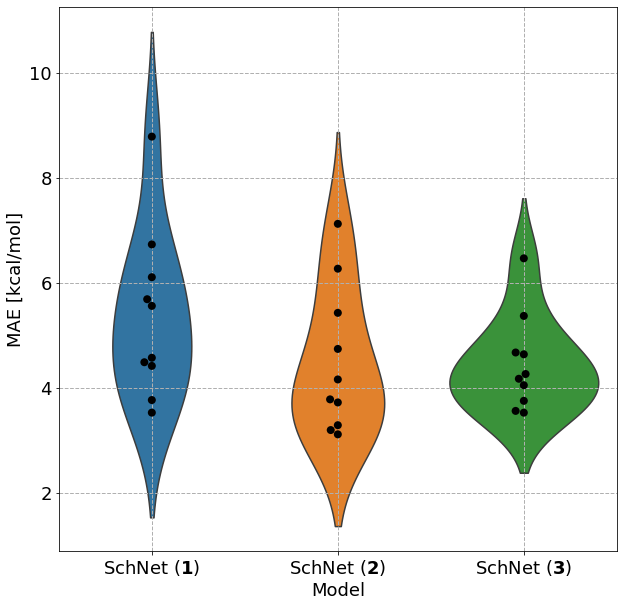

In [3]:
mae_per_fold_schnet = np.load('mae_per_fold_schnet.npy')
mae_per_fold_schnet_descriptors = np.load('mae_per_fold_schnet_descriptors.npy')
mae_per_fold_schnet_noBDEs = np.load('mae_per_fold_schnet_descriptors_noBDEs.npy')

df_schnet = pd.DataFrame({'Model': [
    *[r'SchNet ($\bf{1}$)' for i in range(len(mae_per_fold_schnet))],
    *[r'SchNet ($\bf{2}$)' for i in range(len(mae_per_fold_schnet_descriptors))],
    *[r'SchNet ($\bf{3}$)' for i in range(len(mae_per_fold_schnet_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_schnet, *mae_per_fold_schnet_descriptors, *mae_per_fold_schnet_noBDEs]})

df_schnet.to_csv('cross_val_scores_schnet.csv')

plot_cross_val_scores(df_schnet)
plt.show()

In [5]:
print(len(mae_per_fold_schnet), len(mae_per_fold_schnet_descriptors), len(mae_per_fold_schnet_noBDEs))

10 10 10


# MEGNet

In [ ]:
#! /hits/fast/mbm/treydewk/conda/envs/conda_tflow/bin/python
from kgcnn.utils.adj import coordinates_to_distancematrix, define_adjacency_from_distance, distance_to_gauss_basis, get_angle_indices, sort_edge_indices
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import tensorflow as tf
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from kgcnn.layers.casting import ChangeTensorType
from kgcnn.layers.geom import NodeDistanceEuclidean, GaussBasisLayer, NodePosition
from kgcnn.layers.conv.megnet_conv import MEGnetBlock
from kgcnn.layers.modules import DenseEmbedding, LazyAdd, DropoutEmbedding
from kgcnn.layers.mlp import GraphMLP, MLP
from kgcnn.layers.pooling import PoolingGlobalEdges, PoolingNodes
from kgcnn.layers.pool.set2set import PoolingSet2Set
from kgcnn.utils.models import generate_embedding, update_model_kwargs
from sklearn.model_selection import KFold


def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 1,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    mae_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(6150), targets):
  
        model.compile(loss=loss, optimizer=optimizer)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, N_atoms_train, N_atoms_val = train_test_split(targets[train], inputs[0][train], inputs[1][train], inputs[2][train], inputs[3][train], test_size = 0.2)

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)
        N_atoms_train, N_atoms_val = ragged_tensor_from_nested_numpy(N_atoms_train), ragged_tensor_from_nested_numpy(N_atoms_val)

        data_train = nodes_train, pos_train, edge_idx_train, N_atoms_train
        data_val = nodes_val, pos_val, edge_idx_val, N_atoms_val

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        N_atoms_test = ragged_tensor_from_nested_numpy(inputs[3][test])
        data_test = nodes_test, pos_test, edge_idx_test, N_atoms_test
        scores = model.evaluate(data_test, targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores}')
        mae_per_fold.append(scores)
      
        fold_no = fold_no + 1
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(mae_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - MAE: {mae_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
    print('------------------------------------------------------------------------')
  
    return mae_per_fold

model_default = {'name': "Megnet",
                 'inputs': [{'shape': (None,), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 3), 'name': "node_coordinates", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True},
                            {'shape': [], 'name': "graph_attributes", 'dtype': 'float32', 'ragged': False},
                            {'shape': (25,), 'name': 'input_desc', 'dtype': 'float32', 'ragged': True}],
                 'input_embedding': {"node": {"input_dim": 95, "output_dim": 64},
                                     "graph": {"input_dim": 100, "output_dim": 64}},
                 "make_distance": True, "expand_distance": True,
                 'gauss_args': {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
                 'meg_block_args': {'node_embed': [64, 32, 32], 'edge_embed': [64, 32, 32],
                                    'env_embed': [64, 32, 32], 'activation': 'kgcnn>softplus2'},
                 'set2set_args': {'channels': 16, 'T': 3, "pooling_method": "mean", "init_qstar": "0"},
                 'node_ff_args': {"units": [64, 32], "activation": "kgcnn>softplus2"},
                 'edge_ff_args': {"units": [64, 32], "activation": "kgcnn>softplus2"},
                 'state_ff_args': {"units": [64, 32], "activation": "kgcnn>softplus2"},
                 'nblocks': 3, 'has_ff': True, 'dropout': None, 'use_set2set': True,
                 'verbose': 10,
                 'output_embedding': 'graph',
                 'output_mlp': {"use_bias": [True, True, True], "units": [128, 64, 1],
                                "activation": ['kgcnn>softplus2', 'kgcnn>softplus2', 'linear']}
                 }

@update_model_kwargs(model_default)
def megnet(inputs=None,
               input_embedding=None,
               expand_distance=None,
               make_distance=None,
               gauss_args=None,
               meg_block_args=None,
               set2set_args=None,
               node_ff_args=None,
               edge_ff_args=None,
               state_ff_args=None,
               use_set2set=None,
               nblocks=None,
               has_ff=None,
               dropout=None,
               name=None,
               verbose=None,
               output_embedding=None,
               output_mlp=None
               ):
    """Make MegNet graph network via functional API. Default parameters can be found in :obj:`model_default`.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        input_embedding (dict): Dictionary of embedding arguments for nodes etc. unpacked in `Embedding` layers.
        make_distance (bool): Whether input is distance or coordinates at in place of edges.
        expand_distance (bool): If the edge input are actual edges or node coordinates instead that are expanded to
            form edges with a gauss distance basis given edge indices indices. Expansion uses `gauss_args`.
        gauss_args (dict): Dictionary of layer arguments unpacked in `GaussBasisLayer` layer.
        meg_block_args (dict): Dictionary of layer arguments unpacked in `MEGnetBlock` layer.
        set2set_args (dict): Dictionary of layer arguments unpacked in `PoolingSet2Set` layer.
        node_ff_args (dict): Dictionary of layer arguments unpacked in `MLP` feed-forward layer.
        edge_ff_args (dict): Dictionary of layer arguments unpacked in `MLP` feed-forward layer.
        state_ff_args (dict): Dictionary of layer arguments unpacked in `MLP` feed-forward layer.
        use_set2set (bool): Whether to use `PoolingSet2Set` layer.
        nblocks (int): Number of graph embedding blocks or depth of the network.
        has_ff (bool): Use feed-forward MLP in each block.
        dropout (int): Dropout to use. Default is None.
        name (str): Name of the model.
        verbose (int): Verbosity level of print.
        output_embedding (str): Main embedding task for graph network. Either "node", ("edge") or "graph".
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification `MLP` layer block.
            Defines number of model outputs and activation.

    Returns:
        tf.keras.models.Model
    """

    # Make input
    node_input = tf.keras.layers.Input(**inputs[0])
    xyz_input = tf.keras.layers.Input(**inputs[1])
    edge_index_input = tf.keras.layers.Input(**inputs[2])
    env_input = tf.keras.Input(**inputs[3])
    descriptors = tf.keras.layers.Input(**inputs[4])

    # embedding, if no feature dimension
    n = OptionalInputEmbedding(**input_embedding['node'],
                               use_embedding=len(inputs[0]['shape']) < 2)(node_input)
    uenv = OptionalInputEmbedding(**input_embedding['graph'],
                                  use_embedding=len(inputs[3]['shape']) < 1)(env_input)
    edi = edge_index_input

    # Edge distance as Gauss-Basis
    if make_distance:
        x = xyz_input
        pos1, pos2 = NodePosition()([x, edi])
        ed = NodeDistanceEuclidean()([pos1, pos2])
    else:
        ed = xyz_input

    if expand_distance:
        ed = GaussBasisLayer(**gauss_args)(ed)

    # Model
    vp = n
    ep = ed
    up = uenv
    vp = GraphMLP(**node_ff_args)(vp)
    ep = GraphMLP(**edge_ff_args)(ep)
    up = MLP(**state_ff_args)(up)
    vp2 = vp
    ep2 = ep
    up2 = up
    for i in range(0, nblocks):
        if has_ff and i > 0:
            vp2 = GraphMLP(**node_ff_args)(vp)
            ep2 = GraphMLP(**edge_ff_args)(ep)
            up2 = MLP(**state_ff_args)(up)

        # MEGnetBlock
        vp2, ep2, up2 = MEGnetBlock(**meg_block_args)(
            [vp2, ep2, edi, up2])

        # skip connection
        if dropout is not None:
            vp2 = DropoutEmbedding(dropout, name='dropout_atom_%d' % i)(vp2)
            ep2 = DropoutEmbedding(dropout, name='dropout_bond_%d' % i)(ep2)
            up2 = tf.keras.layers.Dropout(dropout, name='dropout_state_%d' % i)(up2)

        vp = LazyAdd()([vp2, vp])
        ep = LazyAdd()([ep2, ep])
        up = tf.keras.layers.Add()([up2, up])

    if use_set2set:
        vp = DenseEmbedding(set2set_args["channels"], activation='linear')(vp)  # to match units
        ep = DenseEmbedding(set2set_args["channels"], activation='linear')(ep)  # to match units
        vp = PoolingSet2Set(**set2set_args)(vp)
        ep = PoolingSet2Set(**set2set_args)(ep)
    else:
        vp = PoolingNodes()(vp)
        ep = PoolingGlobalEdges()(ep)

    ep = tf.keras.layers.Flatten()(ep)
    vp = tf.keras.layers.Flatten()(vp)
    final_vec = tf.keras.layers.Concatenate(axis=-1)([vp, ep, up, descriptors])

    if dropout is not None:
        final_vec = tf.keras.layers.Dropout(dropout, name='dropout_final')(final_vec)

    # Only graph embedding for Megnet
    if output_embedding != "graph":
        raise ValueError("Unsupported graph embedding for mode `Megnet`.")

    main_output = MLP(**output_mlp)(final_vec)
    model = tf.keras.models.Model(inputs=[node_input, xyz_input, edge_index_input, env_input, descriptors], outputs=main_output)
    return model

data = pd.read_pickle('data_complete_final')
target = data['Ea'].to_numpy()
descriptors = data[[
    'translation', 'rad_BDE', 'H_BDE', 'max_spin_rad',
    'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H',
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
del data

graph_input = pd.read_pickle('graph_input_pickled')
nodes = graph_input['nodes_start'].to_numpy()
pos = graph_input['pos_start'].to_numpy()
edge_idx = graph_input['egde_idx_start'].to_numpy()
N_atoms = graph_input['total_atoms_start'].to_numpy()
del graph_input

input = [nodes, pos, edge_idx, N_atoms, descriptors]

megnet = megnet()

mae_per_fold = K_fold_cross_validation(input, target, 10, megnet)

np.save('mae_per_fold_megnet', mae_per_fold)

## Overview

In [6]:
mae_per_fold_megnet_1_4 = np.load('mae_per_fold_megnet_1_4.npy')
mae_per_fold_megnet_5_7 = np.load('mae_per_fold_megnet_5_7.npy')
mae_per_fold_megnet_8_10 = np.load('mae_per_fold_megnet_8_10.npy')
mae_per_fold_megnet = np.append(mae_per_fold_megnet_1_4, mae_per_fold_megnet_5_7)
mae_per_fold_megnet = np.append(mae_per_fold_megnet, mae_per_fold_megnet_8_10)

mae_per_fold_megnet_descriptors_1_4 = np.load('mae_per_fold_megnet_descriptors_1_4.npy')
mae_per_fold_megnet_descriptors_5_7 = np.load('mae_per_fold_megnet_descriptors_5_7.npy')
mae_per_fold_megnet_descriptors_8_10 = np.load('mae_per_fold_megnet_descriptors_8_10.npy')
mae_per_fold_megnet_descriptors = np.append(mae_per_fold_megnet_descriptors_1_4, mae_per_fold_megnet_descriptors_5_7)
mae_per_fold_megnet_descriptors = np.append(mae_per_fold_megnet_descriptors, mae_per_fold_megnet_descriptors_8_10)

mae_per_fold_megnet_noBDEs_1_4 = np.load('mae_per_fold_megnet_descriptors_noBDEs_1_4.npy')
mae_per_fold_megnet_noBDEs_5_7 = np.load('mae_per_fold_megnet_descriptors_noBDEs_5_7.npy')
mae_per_fold_megnet_noBDEs_8_10 = np.load('mae_per_fold_megnet_descriptors_noBDEs_8_10.npy')
mae_per_fold_megnet_noBDEs = np.append(mae_per_fold_megnet_noBDEs_1_4, mae_per_fold_megnet_noBDEs_5_7)
mae_per_fold_megnet_noBDEs = np.append(mae_per_fold_megnet_noBDEs, mae_per_fold_megnet_noBDEs_8_10)

In [7]:
print('Pure:', np.mean(mae_per_fold_megnet), '+-', np.std(mae_per_fold_megnet))
print('W/ descriptors:', np.mean(mae_per_fold_megnet_descriptors), '+-', np.std(mae_per_fold_megnet_descriptors))
print('No BDEs:', np.mean(mae_per_fold_megnet_noBDEs), '+-', np.std(mae_per_fold_megnet_noBDEs))

Pure: 7.535333728790283 +- 1.1677363778805676
W/ descriptors: 6.338248300552368 +- 0.4928963914492773
No BDEs: 6.511008310317993 +- 0.45400173436201047


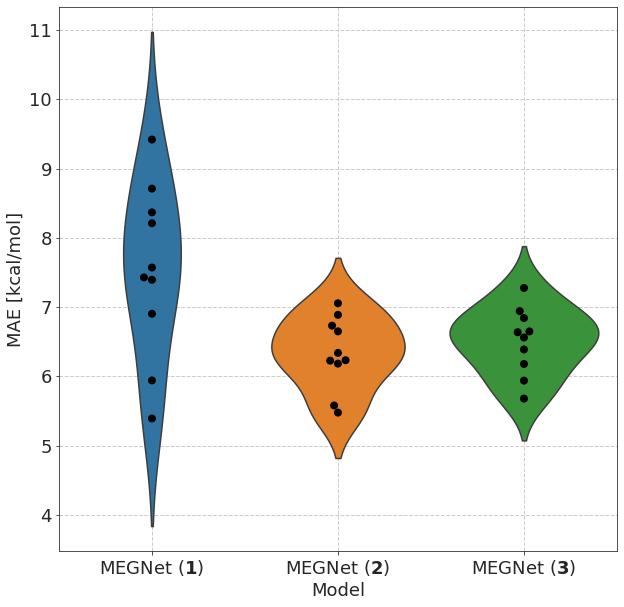

In [8]:
df_megnet = pd.DataFrame({'Model': [
    *[r'MEGNet ($\bf{1}$)' for i in range(len(mae_per_fold_megnet))],
    *[r'MEGNet ($\bf{2}$)' for i in range(len(mae_per_fold_megnet_descriptors))],
    *[r'MEGNet ($\bf{3}$)' for i in range(len(mae_per_fold_megnet_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_megnet, *mae_per_fold_megnet_descriptors, *mae_per_fold_megnet_noBDEs]})

df_megnet.to_csv('cross_val_scores_megnet_compl.csv')

plot_cross_val_scores(df_megnet)
plt.show()

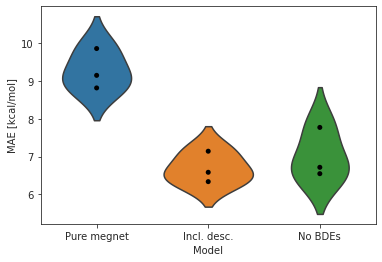

In [7]:
mae_per_fold_megnet = np.load('mae_per_fold_megnet_opt.npy')
mae_per_fold_megnet_descriptors = np.load('mae_per_fold_megnet_descriptors_opt.npy')
mae_per_fold_megnet_noBDEs = np.load('mae_per_fold_megnet_descriptors_noBDEs_opt.npy')

df_megnet = pd.DataFrame({'Model': [
    *['Pure megnet' for i in range(len(mae_per_fold_megnet))],
    *['Incl. desc.' for i in range(len(mae_per_fold_megnet_descriptors))],
    *['No BDEs' for i in range(len(mae_per_fold_megnet_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_megnet, *mae_per_fold_megnet_descriptors, *mae_per_fold_megnet_noBDEs]})

df_megnet.to_csv('cross_val_scores_megnet.csv')

plot_cross_val_scores(df_megnet)
plt.show()



# DimeNet++

In [ ]:
#! /hits/fast/mbm/treydewk/conda/envs/conda_tflow/bin/python
import numpy as np
import pandas as pd
import tensorflow as tf
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from kgcnn.layers.pooling import PoolingGlobalEdges, PoolingNodes
from kgcnn.layers.pool.set2set import PoolingSet2Set
from sklearn.model_selection import KFold
from kgcnn.layers.conv.dimenet_conv import DimNetInteractionPPBlock, DimNetOutputBlock, EmbeddingDimeBlock, \
    SphericalBasisLayer
from kgcnn.layers.gather import GatherNodes
from kgcnn.layers.geom import NodeDistanceEuclidean, EdgeAngle, BesselBasisLayer, NodePosition
from kgcnn.layers.modules import DenseEmbedding, LazyConcatenate, LazyAdd, LazySubtract
from kgcnn.layers.pooling import PoolingNodes
from kgcnn.utils.models import update_model_kwargs
from kgcnn.layers.mlp import MLP
from kgcnn.utils.adj import coordinates_to_distancematrix, define_adjacency_from_distance, get_angle_indices, sort_edge_indices


def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 1,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    mae_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(6150), targets):
  
        model.compile(loss=loss, optimizer=optimizer)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, angle_indices_train, angle_indices_val = train_test_split(targets[train], inputs[0][train], inputs[1][train], inputs[2][train], inputs[3][train], test_size = 0.2)

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)
        angle_indices_train, angle_indices_val = ragged_tensor_from_nested_numpy(angle_indices_train), ragged_tensor_from_nested_numpy(angle_indices_val)


        data_train = nodes_train, pos_train, edge_idx_train, angle_indices_train
        data_val = nodes_val, pos_val, edge_idx_val, angle_indices_train

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        angle_indices_test = ragged_tensor_from_nested_numpy(inputs[3][test])
        data_test = nodes_test, pos_test, edge_idx_test, angle_indices_test
        scores = model.evaluate(data_test, targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores}')
        mae_per_fold.append(scores)
      
        fold_no = fold_no + 1
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(mae_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - MAE: {mae_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
    print('------------------------------------------------------------------------')
  
    return mae_per_fold

model_default = {"name": "DimeNetPP",
                 "inputs": [{"shape": [None], "name": "node_attributes", "dtype": "float32", "ragged": True},
                            {"shape": [None, 3], "name": "node_coordinates", "dtype": "float32", "ragged": True},
                            {"shape": [None, 2], "name": "edge_indices", "dtype": "int64", "ragged": True},
                            {"shape": [None, 2], "name": "angle_indices", "dtype": "int64", "ragged": True},
                            {'shape': (25,), 'name': 'input_desc', 'dtype': 'float32', 'ragged': True}],
                 "input_embedding": {"node": {"input_dim": 95, "output_dim": 128,
                                              "embeddings_initializer": {"class_name": "RandomUniform",
                                                                         "config": {"minval": -1.7320508075688772,
                                                                                    "maxval": 1.7320508075688772}}}},
                 "emb_size": 128, "out_emb_size": 256, "int_emb_size": 64, "basis_emb_size": 8,
                 "num_blocks": 4, "num_spherical": 7, "num_radial": 6,
                 "cutoff": 5.0, "envelope_exponent": 5,
                 "num_before_skip": 1, "num_after_skip": 2, "num_dense_output": 3,
                 "num_targets": 64, "extensive": False, "output_init": "zeros",
                 "activation": "swish", "verbose": 1,
                 "output_embedding": "graph",
                 "use_output_mlp": True,
                 "output_mlp": {"use_bias": [True, False],
                                "units": [64, 12], "activation": ["swish", "linear"]}
                 }

@update_model_kwargs(model_default)
def dimenet(inputs=None,
               input_embedding=None,
               emb_size=None,
               out_emb_size=None,
               int_emb_size=None,
               basis_emb_size=None,
               num_blocks=None,
               num_spherical=None,
               num_radial=None,
               cutoff=None,
               envelope_exponent=None,
               num_before_skip=None,
               num_after_skip=None,
               num_dense_output=None,
               num_targets=None,
               activation=None,
               extensive=None,
               output_init=None,
               verbose=None,
               name=None,
               output_embedding=None,
               use_output_mlp=None,
               output_mlp=None
               ):
    """Make DimeNetPP graph network via functional API. Default parameters can be found in :obj:`model_default`.

    Note: DimeNetPP does require a large amount of memory for this implementation, which increase quickly with
        the number of connections in a batch.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        input_embedding (dict): Dictionary of embedding arguments for nodes etc. unpacked in `Embedding` layers.
        emb_size (int): Overall embedding size used for the messages.
        out_emb_size (int): Embedding size for output of `DimNetOutputBlock`.
        int_emb_size (int): Embedding size used for interaction triplets.
        basis_emb_size (int): Embedding size used inside the basis transformation.
        num_blocks (int): Number of graph embedding blocks or depth of the network.
        num_spherical (int): Number of spherical components in `SphericalBasisLayer`.
        num_radial (int): Number of radial components in basis layer.
        cutoff (float): Distance cutoff for basis layer.
        envelope_exponent (int): Exponent in envelope function for basis layer.
        num_before_skip (int): Number of residual layers in interaction block before skip connection
        num_after_skip (int): Number of residual layers in interaction block after skip connection
        num_dense_output (int): Number of dense units in output `DimNetOutputBlock`.
        num_targets (int): Number of targets or output embedding dimension of the model.
        activation (str, dict): Activation to use.
        extensive (bool): Graph output for extensive target to apply sum for pooling or mean otherwise.
        output_init (str, dict): Output initializer for kernel.
        verbose (int): Level of verbosity.
        name (str): Name of the model.
        output_embedding (str): Main embedding task for graph network. Either "node", ("edge") or "graph".
        use_output_mlp (bool): Whether to use the final output MLP. Possibility to skip final MLP.
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification `MLP` layer block.
            Defines number of model outputs and activation. Note that DimeNetPP originally defines the output dimension
            via `num_targets`. But this can be set to `out_emb_size` and the `output_mlp`  be used for more
            specific control.

    Returns:
        tf.keras.models.Model
    """
    # Make input
    node_input = tf.keras.layers.Input(**inputs[0])
    xyz_input = tf.keras.layers.Input(**inputs[1])
    bond_index_input = tf.keras.layers.Input(**inputs[2])
    angle_index_input = tf.keras.layers.Input(**inputs[3])
    descriptors = tf.keras.layers.Input(**inputs[4])

    # Atom embedding
    # n = generate_node_embedding(node_input, input_node_shape, input_embedding["nodes"])
    if len(inputs[0]["shape"]) == 1:
        n = EmbeddingDimeBlock(**input_embedding["node"])(node_input)
    else:
        n = node_input

    x = xyz_input
    edi = bond_index_input
    adi = angle_index_input

    # Calculate distances
    pos1, pos2 = NodePosition()([x, edi])
    d = NodeDistanceEuclidean()([pos1, pos2])
    rbf = BesselBasisLayer(num_radial=num_radial, cutoff=cutoff, envelope_exponent=envelope_exponent)(d)

    # Calculate angles
    v12 = LazySubtract()([pos1, pos2])
    a = EdgeAngle()([v12, adi])
    sbf = SphericalBasisLayer(num_spherical=num_spherical, num_radial=num_radial, cutoff=cutoff,
                              envelope_exponent=envelope_exponent)([d, a, adi])

    # Embedding block
    rbf_emb = DenseEmbedding(emb_size, use_bias=True, activation=activation,
                             kernel_initializer="kgcnn>glorot_orthogonal")(rbf)
    n_pairs = GatherNodes()([n, edi])
    x = LazyConcatenate(axis=-1)([n_pairs, rbf_emb])
    x = DenseEmbedding(emb_size, use_bias=True, activation=activation, kernel_initializer="kgcnn>glorot_orthogonal")(x)
    ps = DimNetOutputBlock(emb_size, out_emb_size, num_dense_output, num_targets=num_targets,
                           output_kernel_initializer=output_init)([n, x, rbf, edi])

    # Interaction blocks
    add_xp = LazyAdd()
    for i in range(num_blocks):
        x = DimNetInteractionPPBlock(emb_size, int_emb_size, basis_emb_size, num_before_skip, num_after_skip)(
            [x, rbf, sbf, adi])
        p_update = DimNetOutputBlock(emb_size, out_emb_size, num_dense_output, num_targets=num_targets,
                                     output_kernel_initializer=output_init)([n, x, rbf, edi])
        ps = add_xp([ps, p_update])

    if extensive:
        main_output = PoolingNodes(pooling_method="sum")(ps)
    else:
        main_output = PoolingNodes(pooling_method="mean")(ps)

    if use_output_mlp:
        main_output = tf.keras.layers.Concatenate()([main_output, descriptors])
        main_output = MLP(**output_mlp)(main_output)

    if output_embedding != "graph":
        raise ValueError("Unsupported graph embedding for mode `DimeNetPP`.")

    model = tf.keras.models.Model(inputs=[node_input, xyz_input, bond_index_input, angle_index_input, descriptors],
                                  outputs=main_output)

    return model


dimenet = dimenet()

print('Succesfully built model.')

data = pd.read_pickle('data_complete_final')
target = data['Ea'].to_numpy()
descriptors = data[[
    'translation', 'rad_BDE', 'H_BDE', 'max_spin_rad',
    'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H',
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
del data

graph_input = pd.read_pickle('graph_input_pickled')
nodes = graph_input['nodes_start'].to_numpy()
pos = graph_input['pos_start'].to_numpy()
edge_idx = graph_input['egde_idx_start'].to_numpy()

dist_mat_start = [coordinates_to_distancematrix(x) for x in pos]
adj_mat_start = [define_adjacency_from_distance(x)[0] for x in dist_mat_start]
edge_idx = [x if x[0,1]==1 else sort_edge_indices(np.concatenate([np.array([[0, 1], [1,0]]), x], axis=0)) for x in edge_idx]
angle_indices = [get_angle_indices(x)[2] for x in edge_idx]
edge_idx = np.array(edge_idx)
angle_indices = np.array(angle_indices)
del graph_input

input = [nodes, pos, edge_idx, angle_indices]

mae_per_fold = K_fold_cross_validation(input, target, 10, dimenet)

np.save('mae_per_fold_dimenet', mae_per_fold)

## Overview

In [41]:
from pathlib import Path
import re

In [46]:
cwd = Path.cwd() 
dimenet_vals = [f for f in cwd.iterdir() if (re.search('dimenet', str(f.resolve)) and f.suffix=='.npy')]
print([d.name for d in dimenet_vals])

['mae_per_fold_dimenet_9.npy', 'mae_per_fold_dimenet_descriptors_8.npy', 'mae_per_fold_dimenet_3.npy', 'mae_per_fold_dimenet_0.npy']


In [47]:
for d in dimenet_vals:
    d_arr = np.load(d.name)
    print(d.stem, d_arr)

mae_per_fold_dimenet_9 [7.329]
mae_per_fold_dimenet_descriptors_8 [6.405]
mae_per_fold_dimenet_3 [6.636]
mae_per_fold_dimenet_0 [6.339]


In [48]:
mae_per_fold_dimenet = np.array([7.329, 6.636, 6.339])
print(np.mean(mae_per_fold_dimenet), '+-', np.std(mae_per_fold_dimenet))

6.768000000000001 +- 0.4148035679692254


# PaiNN

## Pooling all nodes

In [ ]:
#! /hits/fast/mbm/treydewk/conda/envs/conda_tflow/bin/python
import numpy as np
import pandas as pd
import tensorflow as tf
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from kgcnn.utils.adj import coordinates_to_distancematrix, define_adjacency_from_distance, get_angle_indices, sort_edge_indices
from kgcnn.layers.casting import ChangeTensorType
from kgcnn.layers.conv.painn_conv import PAiNNUpdate, EquivariantInitialize
from kgcnn.layers.conv.painn_conv import PAiNNconv
from kgcnn.layers.geom import NodeDistanceEuclidean, BesselBasisLayer, EdgeDirectionNormalized, CosCutOffEnvelope, NodePosition
from kgcnn.layers.modules import LazyAdd, OptionalInputEmbedding
from kgcnn.layers.mlp import GraphMLP, MLP
from kgcnn.layers.pooling import PoolingNodes
from kgcnn.utils.models import update_model_kwargs
from sklearn.preprocessing import StandardScaler


def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 1,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    mae_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(6150), targets):
  
        model.compile(loss=loss, optimizer=optimizer)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, \
                descriptors_train, descriptors_val = train_test_split(targets[train], inputs[0][train], inputs[1][train], inputs[2][train], inputs[3][train], test_size = 0.2)

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)

        data_train = nodes_train, pos_train, edge_idx_train, descriptors_train
        data_val = nodes_val, pos_val, edge_idx_val, descriptors_val

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        data_test = nodes_test, pos_test, edge_idx_test, inputs[3][test]
        scores = model.evaluate(data_test, targets[test], verbose=0)
        
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores}')
        mae_per_fold.append(scores)
      
        fold_no = fold_no + 1
    
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(mae_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - MAE: {mae_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
    print('------------------------------------------------------------------------')
  
    return mae_per_fold


model_default = {"name": "PAiNN",
                 "inputs": [{"shape": (None,), "name": "node_attributes", "dtype": "float32", "ragged": True},
                            {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
                            {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
                            {'shape': (25,), 'name': 'input_desc', 'dtype': 'float32', 'ragged': True}],
                 "input_embedding": {"node": {"input_dim": 95, "output_dim": 128}},
                 "bessel_basis": {"num_radial": 20, "cutoff": 5.0, "envelope_exponent": 5},
                 "pooling_args": {"pooling_method": "sum"}, # perhaps change to mean
                 "conv_args": {"units": 128, "cutoff": None, "conv_pool": "sum"},
                 "update_args": {"units": 128},
                 "depth": 2,
                 "verbose": 10,
                 "output_embedding": "graph",
                 "output_mlp": {"use_bias": [True, True], "units": [128, 1], "activation": ["swish", "linear"]}
                 }


@update_model_kwargs(model_default)
def painn(inputs=None,
               input_embedding=None,
               bessel_basis=None,
               depth=None,
               pooling_args=None,
               conv_args=None,
               update_args=None,
               name=None,
               verbose=None,
               output_embedding=None,
               output_mlp=None
               ):
    """Make PAiNN graph network via functional API. Default parameters can be found in :obj:`model_default`.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        input_embedding (dict): Dictionary of embedding arguments for nodes etc. unpacked in `Embedding` layers.
        bessel_basis (dict): Dictionary of layer arguments unpacked in final `BesselBasisLayer` layer.
        depth (int): Number of graph embedding units or depth of the network.
        pooling_args (dict): Dictionary of layer arguments unpacked in `PoolingNodes` layer.
        conv_args (dict): Dictionary of layer arguments unpacked in `PAiNNconv` layer.
        update_args (dict): Dictionary of layer arguments unpacked in `PAiNNUpdate` layer.
        verbose (int): Level of verbosity.
        name (str): Name of the model.
        output_embedding (str): Main embedding task for graph network. Either "node", ("edge") or "graph".
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification `MLP` layer block.
            Defines number of model outputs and activation.

    Returns:
        tf.keras.models.Model
    """

    # Make input
    node_input = tf.keras.layers.Input(**inputs[0])
    xyz_input = tf.keras.layers.Input(**inputs[1])
    bond_index_input = tf.keras.layers.Input(**inputs[2])
    descriptors = tf.keras.layers.Input(**inputs[3])
    z = OptionalInputEmbedding(**input_embedding['node'],
                               use_embedding=len(inputs[0]['shape']) < 2)(node_input)

    equiv_input = EquivariantInitialize(dim=3)(z)

    edi = bond_index_input
    x = xyz_input
    v = equiv_input

    pos1, pos2 = NodePosition()([x, edi])
    rij = EdgeDirectionNormalized()([pos1, pos2])
    d = NodeDistanceEuclidean()([pos1, pos2])
    env = CosCutOffEnvelope(conv_args["cutoff"])(d)
    rbf = BesselBasisLayer(**bessel_basis)(d)

    for i in range(depth):
        # Message
        ds, dv = PAiNNconv(**conv_args)([z, v, rbf, env, rij, edi])
        z = LazyAdd()([z, ds])
        v = LazyAdd()([v, dv])
        # Update
        ds, dv = PAiNNUpdate(**update_args)([z, v])
        z = LazyAdd()([z, ds])
        v = LazyAdd()([v, dv])
    n = z
    # Output embedding choice
    if output_embedding == "graph":
        out = PoolingNodes(**pooling_args)(n)
        out = tf.keras.layers.Concatenate()([out, descriptors])
        main_output = MLP(**output_mlp)(out)
    elif output_embedding == "node":
        out = n
        main_output = GraphMLP(**output_mlp)(out)
        main_output = ChangeTensorType(input_tensor_type="ragged", output_tensor_type="tensor")(main_output)
        # no ragged for distribution atm
    else:
        raise ValueError("Unsupported graph embedding for mode `PAiNN`")

    model = tf.keras.models.Model(inputs=[node_input, xyz_input, bond_index_input, descriptors],
                                      outputs=main_output)
    return model


painn = painn()

print('Succesfully built model.')

data = pd.read_pickle('data_complete_final')
target = data['Ea'].to_numpy()
descriptors = data[[
    'translation', 'rad_BDE', 'H_BDE', 'max_spin_rad',
    'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H',
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
del data

# normalize descriptors
descriptors = pd.DataFrame(StandardScaler().fit_transform(descriptors), columns = list(descriptors.columns))
descriptors = np.array(descriptors)

graph_input = pd.read_pickle('graph_input_pickled')
nodes = graph_input['nodes_start'].to_numpy()
pos = graph_input['pos_start'].to_numpy()
edge_idx = graph_input['egde_idx_start'].to_numpy()

dist_mat_start = [coordinates_to_distancematrix(x) for x in pos]
adj_mat_start = [define_adjacency_from_distance(x)[0] for x in dist_mat_start]
edge_idx = [x if x[0,1]==1 else sort_edge_indices(np.concatenate([np.array([[0, 1], [1,0]]), x], axis=0)) for x in edge_idx]
edge_idx = np.array(edge_idx)
del graph_input

input = [nodes, pos, edge_idx, descriptors]

mae_per_fold = K_fold_cross_validation(input, target, 10, painn)

np.save('mae_per_fold_painn_descriptors_dtwo', mae_per_fold)

## Pooling only the reacting H atom in its initial and final position

In [ ]:
#! /hits/fast/mbm/treydewk/conda/envs/conda_tflow/bin/python
import numpy as np
import pandas as pd
import tensorflow as tf
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from kgcnn.utils.adj import coordinates_to_distancematrix, define_adjacency_from_distance, get_angle_indices, sort_edge_indices
from kgcnn.layers.casting import ChangeTensorType
from kgcnn.layers.conv.painn_conv import PAiNNUpdate, EquivariantInitialize
from kgcnn.layers.conv.painn_conv import PAiNNconv
from kgcnn.layers.geom import NodeDistanceEuclidean, BesselBasisLayer, EdgeDirectionNormalized, CosCutOffEnvelope, NodePosition
from kgcnn.layers.modules import LazyAdd, OptionalInputEmbedding
from kgcnn.layers.mlp import GraphMLP, MLP
from kgcnn.layers.pooling import PoolingNodes
from kgcnn.utils.models import update_model_kwargs
from sklearn.preprocessing import StandardScaler
from kgcnn.layers.gather import GatherNodes, GatherNodesIngoing


def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 1,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    train_mae_per_fold = []
    val_mae_per_fold = []
    test_mae_per_fold = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(6150), targets):
  
        model.compile(loss=loss, optimizer=optimizer)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, eri_n_train, eri_n_val, \
                eri_e_train, eri_e_val, descriptors_train, descriptors_val = train_test_split(
                    targets[train], inputs[0][train], inputs[1][train], inputs[2][train],
                    inputs[3][train], inputs[4][train], inputs[5][train], test_size = 0.2,
                    random_state=1
                )

        # normalize descriptors
        means = descriptors_train.mean(axis=0)
        stds = descriptors_train.std(axis=0)
        descriptors_train = (descriptors_train - means) / stds
        descriptors_val = (descriptors_val - means) / stds

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)
        eri_n_train, eri_n_val = ragged_tensor_from_nested_numpy(eri_n_train), ragged_tensor_from_nested_numpy(eri_n_val)
        eri_e_train, eri_e_val = ragged_tensor_from_nested_numpy(eri_e_train), ragged_tensor_from_nested_numpy(eri_e_val)

        data_train = nodes_train, pos_train, edge_idx_train, eri_n_train, eri_e_train, descriptors_train
        data_val = nodes_val, pos_val, edge_idx_val, eri_n_val, eri_e_val, descriptors_val

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        train_scores = model.evaluate(data_train, targets_train, verbose=0, batch_size=batch_size)
        val_scores = model.evaluate(data_val, targets_val, verbose=0, batch_size=batch_size)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        eri_n_test = ragged_tensor_from_nested_numpy(inputs[3][test])
        eri_e_test = ragged_tensor_from_nested_numpy(inputs[4][test])

        descriptors_test = inputs[5][test]
        descriptors_test = (descriptors_test - means) / stds

        data_test = nodes_test, pos_test, edge_idx_test, eri_n_test, eri_e_test, descriptors_test

        test_scores = model.evaluate(data_test, targets[test], verbose=0, batch_size=batch_size)
        
        train_mae_per_fold.append(train_scores)
        val_mae_per_fold.append(val_scores)
        test_mae_per_fold.append(test_scores)
      
        fold_no = fold_no + 1
  
    return train_mae_per_fold, val_mae_per_fold, test_mae_per_fold


model_default = {"name": "PAiNN",
                 "inputs": [{"shape": (None,), "name": "node_attributes", "dtype": "float32", "ragged": True},
                            {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
                            {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
                            {'shape': (None, 2), 'name': 'node_radical_input', 'dtype': 'int64', 'ragged': True},
                            {'shape': (None, 1), 'name': 'edge_radical_input', 'dtype': 'int64', 'ragged': True},
                            {'shape': (25,), 'name': 'input_desc', 'dtype': 'float32', 'ragged': True}],
                 "input_embedding": {"node": {"input_dim": 95, "output_dim": 128}},
                 "bessel_basis": {"num_radial": 20, "cutoff": 5.0, "envelope_exponent": 5},
                 "pooling_args": {"pooling_method": "sum"}, # perhaps change to mean
                 "conv_args": {"units": 128, "cutoff": None, "conv_pool": "sum"},
                 "update_args": {"units": 128},
                 "depth": 2,
                 "verbose": 10,
                 "output_embedding": "graph",
                 "output_mlp": {"use_bias": [True, True, True, True, True], "units": [512, 256, 128, 64, 1], "activation": ["swish", "swish", "swish", "swish", "linear"]}
                 }


@update_model_kwargs(model_default)
def painn(inputs=None,
               input_embedding=None,
               bessel_basis=None,
               depth=None,
               pooling_args=None,
               conv_args=None,
               update_args=None,
               name=None,
               verbose=None,
               output_embedding=None,
               output_mlp=None
               ):
    """Make PAiNN graph network via functional API. Default parameters can be found in :obj:`model_default`.

    Args:
        inputs (list): List of dictionaries unpacked in :obj:`tf.keras.layers.Input`. Order must match model definition.
        input_embedding (dict): Dictionary of embedding arguments for nodes etc. unpacked in `Embedding` layers.
        bessel_basis (dict): Dictionary of layer arguments unpacked in final `BesselBasisLayer` layer.
        depth (int): Number of graph embedding units or depth of the network.
        pooling_args (dict): Dictionary of layer arguments unpacked in `PoolingNodes` layer.
        conv_args (dict): Dictionary of layer arguments unpacked in `PAiNNconv` layer.
        update_args (dict): Dictionary of layer arguments unpacked in `PAiNNUpdate` layer.
        verbose (int): Level of verbosity.
        name (str): Name of the model.
        output_embedding (str): Main embedding task for graph network. Either "node", ("edge") or "graph".
        output_mlp (dict): Dictionary of layer arguments unpacked in the final classification `MLP` layer block.
            Defines number of model outputs and activation.

    Returns:
        tf.keras.models.Model
    """

    # Make input
    node_input = tf.keras.layers.Input(**inputs[0])
    xyz_input = tf.keras.layers.Input(**inputs[1])
    bond_index_input = tf.keras.layers.Input(**inputs[2])
    node_radical_index = tf.keras.layers.Input(**inputs[3])
    edge_radical_index = tf.keras.layers.Input(**inputs[4])
    eri_n = node_radical_index
    eri_e = edge_radical_index
    descriptors = tf.keras.layers.Input(**inputs[5])
    z = OptionalInputEmbedding(**input_embedding['node'],
                               use_embedding=len(inputs[0]['shape']) < 2)(node_input)

    equiv_input = EquivariantInitialize(dim=3)(z)

    edi = bond_index_input
    x = xyz_input
    v = equiv_input

    pos1, pos2 = NodePosition()([x, edi])
    rij = EdgeDirectionNormalized()([pos1, pos2])
    d = NodeDistanceEuclidean()([pos1, pos2])
    env = CosCutOffEnvelope(conv_args["cutoff"])(d)
    rbf = BesselBasisLayer(**bessel_basis)(d)

    for i in range(depth):
        # Message
        ds, dv = PAiNNconv(**conv_args)([z, v, rbf, env, rij, edi])
        z = LazyAdd()([z, ds])
        v = LazyAdd()([v, dv])
        # Update
        ds, dv = PAiNNUpdate(**update_args)([z, v])
        z = LazyAdd()([z, ds])
        v = LazyAdd()([v, dv])
    n = z

    n_radical = GatherNodes()([n, eri_n])
    e_radical = GatherNodesIngoing()([rbf, eri_e])

    rad_embedd = tf.keras.layers.Concatenate(axis=-1)([n_radical, e_radical])
    rad_embedd = PoolingNodes(**pooling_args)(rad_embedd)

    out = tf.keras.layers.Concatenate()([rad_embedd, descriptors])

    initial_output = MLP(**output_mlp)(out)
    concat_input = tf.keras.layers.Concatenate(axis=-1)([out, initial_output])
    main_output = MLP(**output_mlp)(concat_input)

    model = tf.keras.models.Model(inputs=[
        node_input, xyz_input, bond_index_input, node_radical_index, edge_radical_index, descriptors
    ], outputs=main_output)
    return model


painn = painn()

print('Succesfully built model.')

data = pd.read_pickle('data_complete_final')
target = data['Ea'].to_numpy()
descriptors = data[[
    'translation', 'rad_BDE', 'H_BDE', 'max_spin_rad',
    'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H',
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
del data

descriptors = np.array(descriptors)

graph_input = pd.read_pickle('graph_input_pickled')
nodes = graph_input['nodes_start'].to_numpy()
pos = graph_input['pos_start'].to_numpy()
edge_idx = graph_input['egde_idx_start'].to_numpy()

dist_mat_start = [coordinates_to_distancematrix(x) for x in pos]
adj_mat_start = [define_adjacency_from_distance(x)[0] for x in dist_mat_start]
edge_idx = [x if x[0,1]==1 else sort_edge_indices(np.concatenate([np.array([[0, 1], [1,0]]), x], axis=0)) for x in edge_idx]
edge_idx = np.array(edge_idx)
node_radical_index = [np.array([[0, 1]]) for _ in edge_idx]  
edge_radical_index = [np.array([[0]]) for _ in node_radical_index]
node_radical_index = np.array(node_radical_index)
edge_radical_index = np.array(edge_radical_index)
del graph_input

input = [nodes, pos, edge_idx, node_radical_index, edge_radical_index, descriptors]

train_mae_per_fold, val_mae_per_fold, \
    test_mae_per_fold = K_fold_cross_validation(input, target, 10, painn, batch_size=256, no_epochs=1000)

results = pd.DataFrame(
    zip(train_mae_per_fold, val_mae_per_fold, test_mae_per_fold),
    columns=['train_maes', 'val_maes', 'test_maes']
)

results.to_csv('maes_per_fold_final_painn_descriptors_all_dist_w_seed.csv')

In [ ]:
### With predictions

def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 1,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    train_mae_per_fold = []; val_mae_per_fold = []; test_mae_per_fold = []
    train_predictions = []; val_predictions = []; test_predictions = []
    true_train = []; true_val = []; true_test = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(5262), targets):
  
        model.compile(loss=loss, optimizer=optimizer)
                    
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, eri_n_train, eri_n_val, \
                eri_e_train, eri_e_val, descriptors_train, descriptors_val = train_test_split(
                    targets[train], inputs[0][train], inputs[1][train], inputs[2][train],
                    inputs[3][train], inputs[4][train], inputs[5][train], test_size = 0.2, random_state = 1
                )

        # normalize descriptors
        means = descriptors_train.mean(axis=0)
        stds = descriptors_train.std(axis=0)
        descriptors_train = (descriptors_train - means) / stds
        descriptors_val = (descriptors_val - means) / stds

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)
        eri_n_train, eri_n_val = ragged_tensor_from_nested_numpy(eri_n_train), ragged_tensor_from_nested_numpy(eri_n_val)
        eri_e_train, eri_e_val = ragged_tensor_from_nested_numpy(eri_e_train), ragged_tensor_from_nested_numpy(eri_e_val)

        data_train = nodes_train, pos_train, edge_idx_train, eri_n_train, eri_e_train, descriptors_train
        data_val = nodes_val, pos_val, edge_idx_val, eri_n_val, eri_e_val, descriptors_val

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        train_scores = model.evaluate(data_train, targets_train, verbose=0, batch_size=batch_size)
        val_scores = model.evaluate(data_val, targets_val, verbose=0, batch_size=batch_size)
        train_pred = model.predict(data_train)
        val_pred = model.predict(data_val)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        eri_n_test = ragged_tensor_from_nested_numpy(inputs[3][test])
        eri_e_test = ragged_tensor_from_nested_numpy(inputs[4][test])

        descriptors_test = inputs[5][test]
        descriptors_test = (descriptors_test - means) / stds

        data_test = nodes_test, pos_test, edge_idx_test, eri_n_test, eri_e_test, descriptors_test
        targets_test = targets[test]

        test_scores = model.evaluate(data_test, targets[test], verbose=0, batch_size=batch_size)
        test_pred = model.predict(data_test)

        train_mae_per_fold.append(train_scores)
        val_mae_per_fold.append(val_scores)
        test_mae_per_fold.append(test_scores)

        train_predictions.append(train_pred)
        val_predictions.append(val_pred)
        test_predictions.append(test_pred)

        true_train.append(targets_train)
        true_val.append(targets_val)
        true_test.append(targets_test)
      
        fold_no = fold_no + 1
  
    return train_mae_per_fold, val_mae_per_fold, test_mae_per_fold, train_predictions, val_predictions, test_predictions, true_train, true_val, true_test

### OR

def K_fold_cross_validation(
  inputs, targets, num_folds, model, loss='mae', batch_size = 32, no_epochs = 100, verbose = 0,
  split = 0.2, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
):
    train_mae_per_fold = []
    val_mae_per_fold = []
    test_mae_per_fold = []
    mean_scores = []
  
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=6150*0.8/batch_size*1000, decay_rate=1, staircase=False
    )
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
  
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 1)
    
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(np.ones(6150), targets):
  
        model.compile(loss=loss, optimizer=optimizer)

        targets_train, targets_val, nodes_train, nodes_val, pos_train, pos_val, \
            edge_idx_train, edge_idx_val, eri_n_train, eri_n_val, \
                eri_e_train, eri_e_val, descriptors_train, descriptors_val = train_test_split(
                    targets[train], inputs[0][train], inputs[1][train], inputs[2][train],
                    inputs[3][train], inputs[4][train], inputs[5][train], test_size = 0.2,
                    random_state=1
                )

        # normalize descriptors
        means = descriptors_train.mean(axis=0)
        stds = descriptors_train.std(axis=0)
        descriptors_train = (descriptors_train - means) / stds
        descriptors_val = (descriptors_val - means) / stds

        nodes_train, nodes_val = ragged_tensor_from_nested_numpy(nodes_train), ragged_tensor_from_nested_numpy(nodes_val)
        pos_train, pos_val = ragged_tensor_from_nested_numpy(pos_train), ragged_tensor_from_nested_numpy(pos_val)
        edge_idx_train, edge_idx_val = ragged_tensor_from_nested_numpy(edge_idx_train), ragged_tensor_from_nested_numpy(edge_idx_val)
        eri_n_train, eri_n_val = ragged_tensor_from_nested_numpy(eri_n_train), ragged_tensor_from_nested_numpy(eri_n_val)
        eri_e_train, eri_e_val = ragged_tensor_from_nested_numpy(eri_e_train), ragged_tensor_from_nested_numpy(eri_e_val)

        data_train = nodes_train, pos_train, edge_idx_train, eri_n_train, eri_e_train, descriptors_train
        data_val = nodes_val, pos_val, edge_idx_val, eri_n_val, eri_e_val, descriptors_val

        history = model.fit(data_train, targets_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbose,
                    validation_data=(data_val, targets_val),
                    callbacks=callbacks)

        train_scores = model.evaluate(data_train, targets_train, verbose=0, batch_size=batch_size)
        val_scores = model.evaluate(data_val, targets_val, verbose=0, batch_size=batch_size)

        nodes_test = ragged_tensor_from_nested_numpy(inputs[0][test])
        pos_test = ragged_tensor_from_nested_numpy(inputs[1][test])
        edge_idx_test = ragged_tensor_from_nested_numpy(inputs[2][test])
        eri_n_test = ragged_tensor_from_nested_numpy(inputs[3][test])
        eri_e_test = ragged_tensor_from_nested_numpy(inputs[4][test])

        descriptors_test = inputs[5][test]
        descriptors_test = (descriptors_test - means) / stds

        data_test = nodes_test, pos_test, edge_idx_test, eri_n_test, eri_e_test, descriptors_test

        test_scores = model.evaluate(data_test, targets[test], verbose=0, batch_size=batch_size)
        
        train_mae_per_fold.append(train_scores)
        val_mae_per_fold.append(val_scores)
        test_mae_per_fold.append(test_scores)

        mean_score = np.mean([train_scores, val_scores, test_scores])
        mean_scores.append(mean_score)

        if mean_score == np.min(mean_scores):
            train_predictions = model.predict(data_train).flatten()
            val_predictions = model.predict(data_val).flatten()
            test_predictions = model.predict(data_test).flatten()
            t_train = targets_train
            t_val = targets_val
            t_test = targets[test]
      
        fold_no = fold_no + 1
  
    return train_mae_per_fold, val_mae_per_fold, test_mae_per_fold, train_predictions, val_predictions, test_predictions, t_train, t_val, t_test

## Comparison

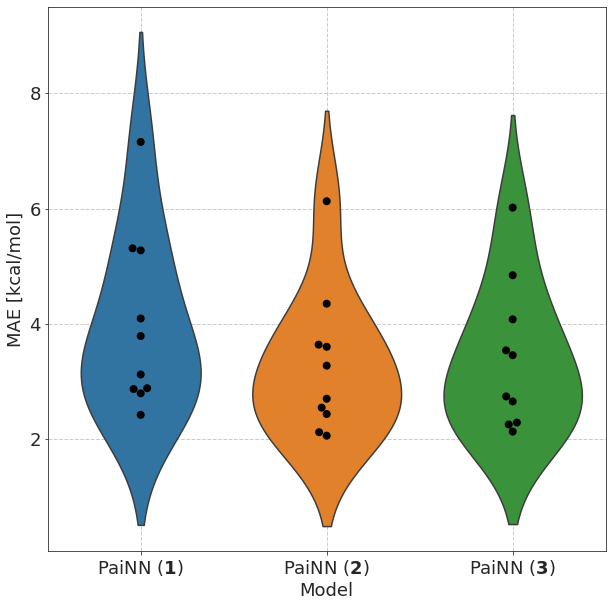

In [9]:
mae_per_fold_painn = np.load('mae_per_fold_painn_dtwo.npy')
mae_per_fold_painn_descriptors = np.load('mae_per_fold_painn_descriptors_dtwo.npy')
mae_per_fold_painn_noBDEs = np.load('mae_per_fold_painn_descriptors_noBDEs_dtwo.npy')

df_painn = pd.DataFrame({'Model': [
    *[r'PaiNN ($\bf{1}$)' for i in range(len(mae_per_fold_painn))],
    *[r'PaiNN ($\bf{2}$)' for i in range(len(mae_per_fold_painn_descriptors))],
    *[r'PaiNN ($\bf{3}$)' for i in range(len(mae_per_fold_painn_noBDEs))]
], 'MAE [kcal/mol]': [*mae_per_fold_painn, *mae_per_fold_painn_descriptors, *mae_per_fold_painn_noBDEs]})

df_painn.to_csv('cross_val_scores_painn.csv')

plot_cross_val_scores(df_painn)
plt.show()



In [10]:
print('Pure:', np.mean(mae_per_fold_painn), '+-', np.std(mae_per_fold_painn))
print('W/ descriptors:', np.mean(mae_per_fold_painn_descriptors), '+-', np.std(mae_per_fold_painn_descriptors))
print('No BDEs:', np.mean(mae_per_fold_painn_noBDEs), '+-', np.std(mae_per_fold_painn_noBDEs))

Pure: 3.967881464958191 +- 1.4369871963002314
W/ descriptors: 3.2813716411590574 +- 1.180916959954812
No BDEs: 3.396327090263367 +- 1.208531629326269


In [12]:
print(len(mae_per_fold_painn), len(mae_per_fold_painn_descriptors), len(mae_per_fold_painn_noBDEs))

10 10 10


## Hyperparamter optimization of final NN

### Skip connections

In [ ]:
final_input = tf.keras.layers.Concatenate()([rad_embedd, descriptors])
# output MLP with skip connections
a = tf.keras.layers.Dense(128, activation='swish')(final_input)
b = tf.keras.layers.Concatenate()([a, final_input])    
c = tf.keras.layers.Dense(64, activation='swish')(b)
d = tf.keras.layers.Concatenate()([b, c])
out = tf.keras.layers.Dense(1, activation='linear')(d)

### Attentive NN

In [ ]:
class attention(tf.keras.layers.Layer):
    def __init__(self, out_shape=32, batch_size=41):
        super(attention, self).__init__()
        self.out_shape = out_shape
        self.batch_size = batch_size

    def build(self, input_shape):
        #key weights
        self.K = self.add_weight(name='key_weight', shape=(input_shape[1], 128), 
                               initializer='glorot_uniform', trainable=True)
        #key bias
        self.K_b = self.add_weight(name='key_bias', shape=(self.batch_size, 128), 
                               initializer='zeros', trainable=True)
        #query weights
        self.Q = self.add_weight(name='query_weight', shape=(input_shape[1], 128), 
                               initializer='glorot_uniform', trainable=True)
        #query bias
        self.Q_b = self.add_weight(name='query_bias', shape=(self.batch_size, 128), 
                               initializer='zeros', trainable=True)
        #value weights
        self.V = self.add_weight(name='value_weight', shape=(input_shape[1], self.out_shape), 
                               initializer='glorot_uniform', trainable=True)
        #value bias
        self.V_b = self.add_weight(name='value_bias', shape=(self.batch_size, self.out_shape), 
                               initializer='zeros', trainable=True)

    def call(self,x):
        keys = tf.matmul(x, self.K) + self.K_b
        queries =  tf.matmul(x, self.Q) + self.Q_b
        values = tf.matmul(x, self.V) + self.V_b
        #attention scores
        attn_scores = tf.nn.softmax(tf.matmul(queries, keys, transpose_b=True))
        weighted_values = tf.matmul(attn_scores, values)
        return weighted_values

final_input = tf.keras.layers.Concatenate()([rad_embedd, descriptors])
# output MLP with attention
a = attention(128)(final_input)
b = tf.keras.layers.Dense(64, activation='swish')(a)
out = tf.keras.layers.Dense(1, activation='linear')(b)   

In [ ]:
class multihead_attention(tf.keras.layers.Layer):
    def __init__(self, out_shape=32):
        super(multihead_attention, self).__init__()
        self.out_shape = out_shape

    def build(self, input_shape):
        #key weights
        self.K = self.add_weight(name='key_weight', shape=(input_shape[1], 64), 
                               initializer='glorot_uniform', trainable=True)
        self.K1 = self.add_weight(name='key_weight1', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        self.K2 = self.add_weight(name='key_weight2', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        self.K3 = self.add_weight(name='key_weight3', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        self.K4 = self.add_weight(name='key_weight4', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        #key bias
        # self.K_b = self.add_weight(name='key_bias', shape=(self.batch_size, 128), 
        #                        initializer='zeros', trainable=True)
        #query weights
        self.Q = self.add_weight(name='query_weight', shape=(input_shape[1], 64), 
                               initializer='glorot_uniform', trainable=True)
        self.Q1 = self.add_weight(name='query_weight1', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        self.Q2 = self.add_weight(name='query_weight2', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        self.Q3 = self.add_weight(name='query_weight3', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        self.Q4 = self.add_weight(name='query_weight4', shape=(64, 64), 
                               initializer='glorot_uniform', trainable=True)
        #query bias
        # self.Q_b = self.add_weight(name='query_bias', shape=(self.batch_size, 128), 
        #                        initializer='zeros', trainable=True)
        #value weights
        self.V = self.add_weight(name='value_weight1', shape=(input_shape[1], self.out_shape), 
                               initializer='glorot_uniform', trainable=True)
        self.V1 = self.add_weight(name='value_weight1', shape=(self.out_shape, self.out_shape), 
                               initializer='glorot_uniform', trainable=True)
        self.V2 = self.add_weight(name='value_weight2', shape=(self.out_shape, self.out_shape), 
                               initializer='glorot_uniform', trainable=True)
        self.V3 = self.add_weight(name='value_weight3', shape=(self.out_shape, self.out_shape), 
                               initializer='glorot_uniform', trainable=True)
        self.V4 = self.add_weight(name='value_weight4', shape=(self.out_shape, self.out_shape), 
                               initializer='glorot_uniform', trainable=True)
        #value bias
        # self.V_b = self.add_weight(name='value_bias', shape=(self.batch_size, self.out_shape), 
        #                        initializer='zeros', trainable=True)
        #output projection
        self.W = self.add_weight(name='output_weight', shape=(4*self.out_shape, self.out_shape), 
                               initializer='glorot_uniform', trainable=True)

    def call(self,x):
        keys = tf.matmul(x, self.K)
        keys1 = tf.matmul(keys, self.K1)
        keys2 = tf.matmul(keys, self.K2)
        keys3 = tf.matmul(keys, self.K3)
        keys4 = tf.matmul(keys, self.K4)
        queries = tf.matmul(x, self.Q)
        queries1 =  tf.matmul(queries, self.Q1)
        queries2 =  tf.matmul(queries, self.Q2)
        queries3 =  tf.matmul(queries, self.Q3)
        queries4 =  tf.matmul(queries, self.Q4)
        values = tf.matmul(x, self.V)
        values1 = tf.matmul(values, self.V1)
        values2 = tf.matmul(values, self.V2)
        values3 = tf.matmul(values, self.V3)
        values4 = tf.matmul(values, self.V4)

        #attention scores
        attn_scores1 = tf.nn.softmax(tf.matmul(queries1, keys1, transpose_b=True))
        attn_scores2 = tf.nn.softmax(tf.matmul(queries2, keys2, transpose_b=True))
        attn_scores3 = tf.nn.softmax(tf.matmul(queries3, keys3, transpose_b=True))
        attn_scores4 = tf.nn.softmax(tf.matmul(queries4, keys4, transpose_b=True))

        weighted_values1 = tf.matmul(attn_scores1, values1)
        weighted_values2 = tf.matmul(attn_scores2, values2)
        weighted_values3 = tf.matmul(attn_scores3, values3)
        weighted_values4 = tf.matmul(attn_scores4, values4)

        weighted_values_stacked = tf.concat([weighted_values1, weighted_values2, weighted_values3, weighted_values4], axis=1)

        weighted_values = tf.matmul(weighted_values_stacked, self.W)

        return weighted_values

# output MLP with attention
a = multihead_attention(128)(final_input)
b = tf.keras.layers.Dense(64, activation='swish')(a)
out = tf.keras.layers.Dense(1, activation='linear')(b)   

## Restricted adjacency matrix

In [ ]:
adj_mat_start = [define_adjacency_from_distance(x, max_distance=3, max_neighbours=4)[0] for x in dist_mat_start]

## Only use data points where H translation is less than 3 A

In [ ]:
# only use data points where translation < 3 A
data = pd.read_pickle('data_complete_final')
data = data.reset_index(drop=True)
to_drop = data[data['translation']>=3.0]
to_drop_arr = to_drop.index.values
data = data.drop(index = to_drop_arr)
target = data['Ea'].to_numpy()
descriptors = data[[
    'translation', 'rad_BDE', 'H_BDE', 'max_spin_rad',
    'mull_charge_rad', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad',
    'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H', 'nBase_H', 'SpMax_A_H',
    'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 
    'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H'
]]
del data

graph_input = pd.read_pickle('graph_input_pickled')
graph_input = graph_input.reset_index(drop=True)
graph_input = graph_input.drop(index = to_drop_arr) # only use data points where translation < 3 A

nodes = graph_input['nodes_start'].to_numpy()
pos = graph_input['pos_start'].to_numpy()
edge_idx = graph_input['egde_idx_start'].to_numpy()

dist_mat_start = [coordinates_to_distancematrix(x) for x in pos]
adj_mat_start = [define_adjacency_from_distance(x)[0] for x in dist_mat_start]
edge_idx = [x if x[0,1]==1 else sort_edge_indices(np.concatenate([np.array([[0, 1], [1,0]]), x], axis=0)) for x in edge_idx]
edge_idx = np.array(edge_idx)
node_radical_index = [np.array([[0, 1]]) for _ in edge_idx]  
edge_radical_index = [np.array([[0]]) for _ in node_radical_index]
node_radical_index = np.array(node_radical_index)
edge_radical_index = np.array(edge_radical_index)
del graph_input

# Complete overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_schnet = pd.read_csv('maes_per_fold/cross_val_scores_schnet.csv', index_col=0)
df_megnet = pd.read_csv('maes_per_fold/cross_val_scores_megnet_compl.csv', index_col=0)
# df_dimenet = pd.read_csv('cross_val_scores_dimenet.csv', index_col=0)
df_painn = pd.read_csv('maes_per_fold/cross_val_scores_painn.csv', index_col=0)

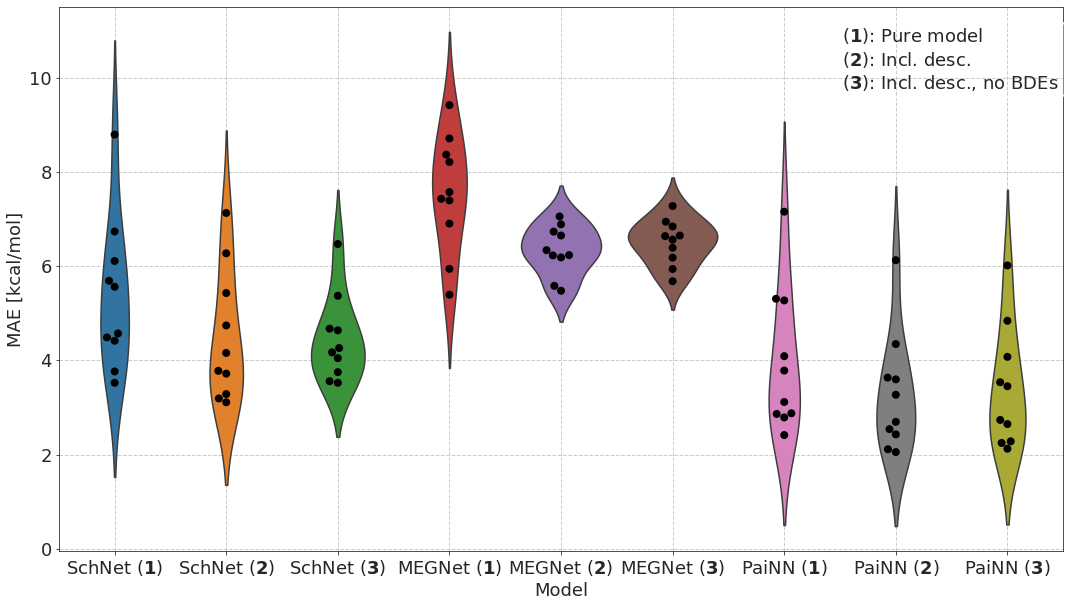

In [49]:
complete_df = pd.concat([df_schnet, df_megnet, df_painn])
complete_df.to_csv('cross_val_scores_GNN_all.csv')

fs = 18
fig, ax = plt.subplots(figsize=(18,10))
sns.set_style('ticks')
ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=complete_df, inner=None, orient='v')
ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=complete_df, color='black', edgecolor='black', size=8)
ax.tick_params(labelsize = fs)
ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
ax.set_xlabel('Model', fontsize=fs)
ax.grid(linestyle='--', linewidth=1)

textstr = r'($\bf{1}$):'+' Pure model\n'+r'($\bf{2}$):'+' Incl. desc.\n'+r'($\bf{3}$):'+' Incl. desc., no BDEs'
props = dict(boxstyle='round', facecolor = 'None', alpha=1)
ax.text(0.78, 0.85, textstr, transform=ax.transAxes, fontsize=fs, bbox=props)
plt.savefig('gnn_compl_overview.png', bbox_inches='tight')

plt.show()

In [4]:
complete_df = pd.concat([df_schnet, df_megnet, df_painn])
# complete_df.to_csv('cross_val_scores_GNN_all.csv')

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

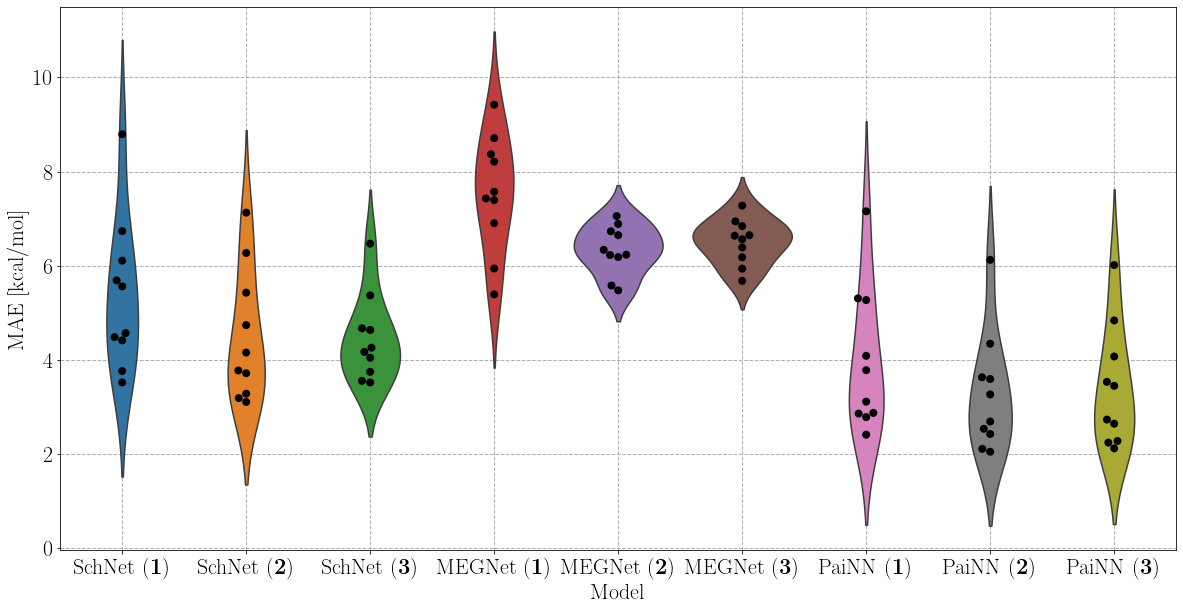

In [6]:
fs = 22
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.violinplot(x="Model", y="MAE [kcal/mol]", data=complete_df, inner=None, orient='v')
ax = sns.swarmplot(x="Model", y="MAE [kcal/mol]", data=complete_df, color='black', edgecolor='black', size=8)
ax.tick_params(labelsize = fs)
ax.set_ylabel('MAE [kcal/mol]', fontsize=fs)
ax.set_xlabel('Model', fontsize=fs)
ax.grid(linestyle='--', linewidth=1)
ax.set_axisbelow(True)
plt.savefig('gnn_compl_overview_report.pdf', bbox_inches='tight', dpi=600)
plt.show()

# Final GNN Model

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

In [9]:
results = pd.read_csv('maes_per_fold/maes_per_fold_final_painn_descriptors_3_A_w_seed_2.csv', index_col=0)

In [10]:
means = []
for train, val, test in zip(results['train_maes'], results['val_maes'], results['test_maes']):
    means.append(np.mean(np.array([train, val, test])))

min_mae_fold = means.index(np.min(means))
print(min_mae_fold, ':', np.min(means))

8 : 0.5113181471824646


In [11]:
y_train_pred = results['train_predictions'].to_list()[min_mae_fold]
y_train_true = results['true_train'].to_list()[min_mae_fold]
y_val_pred = results['val_predictions'].to_list()[min_mae_fold]
y_val_true = results['true_val'].to_list()[min_mae_fold]
y_test_pred = results['test_predictions'].to_list()[min_mae_fold]
y_test_true = results['true_test'].to_list()[min_mae_fold]

y_train_pred = ''.join(y_train_pred.split(sep='['))
y_train_pred = ''.join(y_train_pred.split(sep=']'))
y_train_true = ''.join(y_train_true.split(sep='['))
y_train_true = ''.join(y_train_true.split(sep=']'))
y_val_pred = ''.join(y_val_pred.split(sep='['))
y_val_pred = ''.join(y_val_pred.split(sep=']'))
y_val_true = ''.join(y_val_true.split(sep='['))
y_val_true = ''.join(y_val_true.split(sep=']'))
y_test_pred = ''.join(y_test_pred.split(sep='['))
y_test_pred = ''.join(y_test_pred.split(sep=']'))
y_test_true = ''.join(y_test_true.split(sep='['))
y_test_true = ''.join(y_test_true.split(sep=']'))

# y_train_pred = np.asarray(y_train_pred.split(), dtype=np.float)
# y_train_true = np.asarray(y_train_true.split(), dtype=np.float)
y_val_pred = np.asarray(y_val_pred.split(), dtype=np.float)
y_val_true = np.asarray(y_val_true.split(), dtype=np.float)
y_test_pred = np.asarray(y_test_pred.split(), dtype=np.float)
y_test_true = np.asarray(y_test_true.split(), dtype=np.float)

In [12]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

In [13]:
def plot_results(y_val_pred, y_val_true, y_test_pred, y_test_true): 
    fs = 22
    color_train = 'b'
    color_validation = 'orange'
    color_test = 'g'
    size = 30
    alpha = 0.5
    fig, ax = plt.subplots(figsize=(10,10))
    # sb.set(style="ticks")
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    points_validation = ax.scatter(y_val_true, y_val_pred,
                c = color_validation, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)
    points_test = ax.scatter(y_test_true, y_test_pred,
                c = color_test, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)
    ax.set_xlabel('True barrier [kcal/mol]', fontsize=fs)
    ax.set_ylabel('Predicted barrier [kcal/mol]', fontsize=fs)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=5, labels=['Validation','Test'], fontsize=fs)

    # Add the regression line with a confidence interval based on the training sets
#     plot = sb.regplot(x = y_train_true, y = y_train_pred, scatter=False, color=".1", truncate = False, ax=ax)
    ax.grid(linestyle='--', linewidth=1)

    y_compl = np.concatenate([y_val_true, y_test_true, y_val_pred, y_test_pred])
    size_space = 0.05*abs(min(y_compl)-max(y_compl))
    min_value_graph = min(y_compl)-size_space
    max_value_graph = max(y_compl)+size_space
    plt.xlim(min_value_graph, max_value_graph)
    plt.ylim(min_value_graph, max_value_graph)

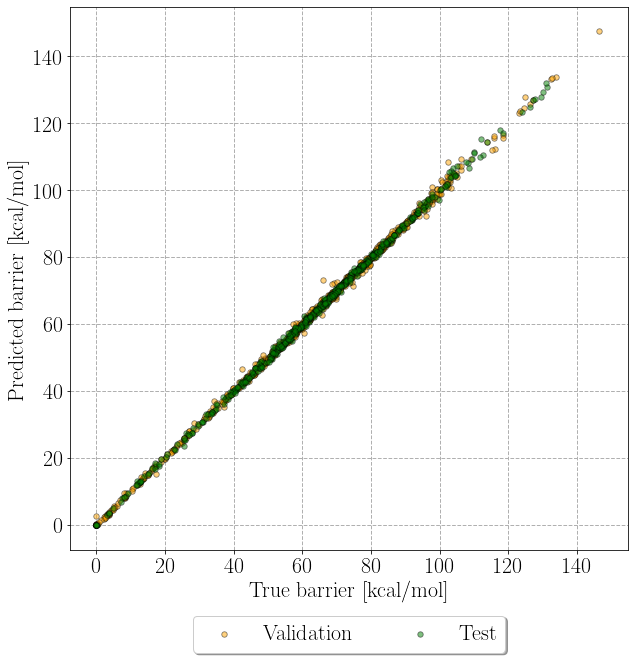

In [14]:
plot_results(y_val_pred, y_val_true, y_test_pred, y_test_true)
plt.savefig('final_predictions_3A_report.pdf', dpi=600, bbox_inches='tight')
plt.show()

# Right-tailed one-sample t-tests
## All H translations

In [1]:
import pandas as pd
import numpy as np

In [2]:
results_pure = pd.read_csv('maes_per_fold/maes_per_fold_final_painn_best_all_dist.csv')

In [3]:
results_descriptors = pd.read_csv('maes_per_fold/maes_per_fold_final_painn_descriptors_all_dist_w_seed.csv')

In [4]:
test_delta = results_pure['test_maes'].to_numpy() - results_descriptors['test_maes'].to_numpy()

In [5]:
print(test_delta)

[ 0.10622096  0.31706095  0.15456986  0.46548188  0.15036464 -0.06778061
 -0.21566975  0.16498792  0.05232316  0.21090567]


In [6]:
np.mean(test_delta)

0.13384646773338318

In [7]:
np.std(test_delta)

0.1792718873081838

In [8]:
from scipy.stats import ttest_1samp

In [11]:
# all distances
res = ttest_1samp(a=test_delta, popmean=0, alternative='greater')
print(res)

Ttest_1sampResult(statistic=2.2398347517247292, pvalue=0.025928626260209763)


## Only H translations less than 3 A

In [13]:
results_pure = pd.read_csv('maes_per_fold/maes_per_fold_final_painn_3_A_w_seed.csv')

In [14]:
results_descriptors = pd.read_csv('maes_per_fold/maes_per_fold_final_painn_descriptors_3_A_w_seed_2.csv')

In [15]:
test_delta = results_pure['test_maes'].to_numpy() - results_descriptors['test_maes'].to_numpy()

In [16]:
print(test_delta)

[ 1.65204763e-01 -1.33808732e-01  3.90207410e-01  4.36520576e-03
  3.13197970e-01  5.21515012e-02  8.44101906e-02  1.59800053e-04
  2.51794398e-01 -4.69754934e-02]


In [17]:
np.mean(test_delta)

0.10807070136070258

In [18]:
np.std(test_delta)

0.159446063836839

In [19]:
res = ttest_1samp(a=test_delta, popmean=0, alternative='greater')
print(res)

Ttest_1sampResult(statistic=2.033365366823189, pvalue=0.03626944387134345)
